# 2017 Gene Expression Analysis
This notebook contains the gene expression analysis for the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). When published, the manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This code is provided for reproducability.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

In [1]:
#library('DESeq2')
library('ggplot2')
library('viridis')
library('tidyverse')
library('rebus')
library('car')
library('emmeans')
library('MASS')
library('randomForest')
library('caret')

Loading required package: viridisLite
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rebus’

The following object is masked from ‘package:stringr’:

    regex

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘

In [2]:
#### Prepare environment, load required data ####

rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
row_palette <- viridis(9)

#HTSeq_dir <- ('./counts')
treatments <- read.csv('2017_treatment_metadata.csv')

#remove samples with few counts or from SO4 overgrowth
treatments <- treatments[treatments$sampleName != 'A1Y1_019_L',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_019_R',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_091_L',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_091_R',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_163_L',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_163_R',] # SO4
treatments <- treatments[treatments$sampleName != 'A1Y1_030_L',] # counts

# refactor as appropriate
treatments$Row <- as.factor(treatments$Row)
treatments <- treatments[c('sampleName', 'fileName', 'Row', 'Rootstock', 'Irrigation', 'Phenology', 'Tissue')]
treatments$Phenology <- factor(treatments$Phenology, levels=c('anthesis', 'veraison', 'harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))
treatments$Tissue <- factor(treatments$Tissue, levels=c('Leaf', 'Reproductive'), labels=c('Leaf', 'Reproductive'))
treatments$Irrigation <- factor(treatments$Irrigation, levels=c('none', 'RDI', 'full'), labels=c('None', 'RDI', 'Full'))
treatments$Rootstock <- factor(treatments$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))

# create block based on row
treatments$Block <- rep('A', dim(treatments)[1])
treatments$Block[treatments$Row == 11] <- "B" 
treatments$Block[treatments$Row == 12] <- "B"
treatments$Block[treatments$Row == 13] <- "B"
treatments$Block[treatments$Row == 14] <- "C"
treatments$Block[treatments$Row == 15] <- "C"
treatments$Block[treatments$Row == 16] <- "C"

# print counts for each factor
table(treatments$Tissue)
table(treatments$Phenology)
table(treatments$Rootstock)
table(treatments$Irrigation)
table(treatments$Block)
table(treatments$Row)


        Leaf Reproductive 
         212          213 


Anthesis Veraison  Harvest 
     141      142      142 


Ungrafted     1103P     3309C       SO4 
      107       108       108       102 


None  RDI Full 
 144  143  138 


  A   B   C 
138 143 144 


 8  9 10 11 12 13 14 15 16 
48 48 42 47 48 48 48 48 48 

## DESeq2

In this approach, I am goint to use DESeq2 to normalize the gene expression data. To do this, I first fit a reduced-complexity model that merges Phenology and Rootstock into one fixed-effect model term. At this point, I treat Block as a true blocking factor despite its correlations with time. I additionally treat irrigation as a blocking factor due to it's lack of signal in other phenotypes. 

In [3]:
# Create interation terms

treatments$group <- paste(treatments$Phenology, treatments$Rootstock, sep='_')
table(treatments$group)

treatments <- treatments[treatments$Tissue == "Leaf",]


    Anthesis_1103P     Anthesis_3309C       Anthesis_SO4 Anthesis_Ungrafted 
                36                 36                 34                 35 
     Harvest_1103P      Harvest_3309C        Harvest_SO4  Harvest_Ungrafted 
                36                 36                 34                 36 
    Veraison_1103P     Veraison_3309C       Veraison_SO4 Veraison_Ungrafted 
                36                 36                 34                 36 

In [4]:
# model cannot include row because row and irrigation correlate
# this was actually done in a different notebook, but this is the block of code that ran it. -ZH

# dds <- DESeqDataSetFromHTSeqCount(sampleTable=treatments, directory=HTSeq_dir, 
#                                   design= ~Block + Irrigation + group)
# dds <- DESeq(dds)
# save(dds, file='./2017_model_refit_elegantInteractions_leafOnly.Rdata')

In [52]:
#load('./2017_model_refit_elegantInteractions_leafOnly.Rdata')

### Approximate PC Space for Weird Genes

Before I dive into proper tranformation techniques, I remove a problematic gene. Notice that PC1 is 93% of the variation. This always happens with this annotation. Without even plotting, I will remove the likely offending gene and rerun.

For Joel: This will actually show the 91% idea and will then skip the plot. I had to pull this down from Apex when my internet was sketchy, and I haven't yet combined the work here with the preliminary analysis on Apex. 

In [6]:
# norm_counts <- counts(dds, normalize=TRUE)
# colnames(norm_counts) <- treatments$sampleName
# norm_count_t <- t(norm_counts)

# pca <- prcomp(norm_count_t)
# x <- summary(pca)
# head(matrix(x$importance, ncol=3, byrow = T), 20) # takes 9 PCs to explain 99%

In [7]:
# # shows it will actually be the gene I am expecting. 
# x <- as.data.frame(pca$rotation)
# rownames(x)[which(x$PC1 == max(x$PC1))]

In [8]:
# norm_count_t <- as.data.frame(norm_count_t)
# colnames(norm_count_t) <- rownames(norm_counts)

# norm_count_t$Vitvi19g01871 <- NULL

# pca <- prcomp(norm_count_t, center=T)
# head(matrix(summary(pca)$importance, ncol=3, byrow = T),20)

In [9]:
# pdf('2017_geneExpression_PCAplots_byFactor.pdf', onefile=T)

# for_plot <- data.frame(pca$x)
# for_plot$Rootstock <- treatments$Rootstock
# p.rootstock <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock)) + 
#                geom_point(aes(shape=Rootstock), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21)) + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))       
# p.rootstock

# for_plot$Phenology <- treatments$Phenology  
# p.phenology <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology)) + 
#                geom_point(aes(shape=Phenology), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21)) + 
#                scale_fill_manual('Phenology', values=p_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.phenology

# for_plot$Irrigation <- treatments$Irrigation  
# p.irrigation <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Irrigation)) + 
#                geom_point(aes(shape=Irrigation), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21)) + 
#                scale_fill_manual('Irrigation', values=i_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.irrigation

# for_plot$Row <- treatments$Row  
# p.block <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row)) + 
#                geom_point(aes(shape=Row), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
#                scale_fill_manual('Row', values=row_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.block

# #dev.off()

## Remove Low Counts and Problematic genes

Here, I filter away low count genes and actually remove the problematic gene from the dds object. I require all genes have a count of at least 2 in at least 5 samples. This is slightly more restrictive than when I built modules, but a lot of those genes needed to be removed. 

In [10]:
# idx <- rowSums( counts(dds, normalized=TRUE) >= 2 ) >= 5
# genes <- rownames(dds)[idx]
# length(genes)


In [11]:
# idx <- idx[-which(genes == 'Vitvi19g01871')]
# genes <- genes[-which(genes == 'Vitvi19g01871')]

In [12]:
# dds_filt <- dds[idx,]
# dds_filt <- DESeq(dds_filt)

In [13]:
# dim(norm_count_t)

In [14]:
# norm_counts <- counts(dds_filt, normalize=TRUE)
# colnames(norm_counts) <- treatments$sampleName
# norm_count_t <- t(norm_counts)

# pca <- prcomp(norm_count_t)
# x <- summary(pca)
# head(matrix(x$importance, ncol=3, byrow = T), 20) 

In [15]:
# for_plot <- data.frame(pca$x)
# for_plot$Rootstock <- treatments$Rootstock
# p.rootstock <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock)) + 
#                geom_point(aes(shape=Rootstock), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21)) + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))       
# p.rootstock

# for_plot$Phenology <- treatments$Phenology  
# p.phenology <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology)) + 
#                geom_point(aes(shape=Phenology), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21)) + 
#                scale_fill_manual('Phenology', values=p_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.phenology

# for_plot$Irrigation <- treatments$Irrigation  
# p.irrigation <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Irrigation)) + 
#                geom_point(aes(shape=Irrigation), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21)) + 
#                scale_fill_manual('Irrigation', values=i_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.irrigation

# for_plot$Row <- treatments$Row  
# p.block <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row)) + 
#                geom_point(aes(shape=Row), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
#                scale_fill_manual('Row', values=row_palette) + 
#                xlab('PC1 (40.6%)') + ylab('PC2 (22.0%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.block

## Variance Stabilizing Transformation

DESeq2 provides a transformation that lends nicely for downstream analysis like PCA and machine learning. This transformation, the VST, was ran using the setting `blind=F` because we expect there to be a large difference in counts due to one of the factors in the experiment (Phenology - encased here in 'group'). Despite this using information from the experimental design to inform the tranformation, the documentation ensures that "is still for the most part not using the information about which samples were in which experimental group in applying the transformation". See section: Blind dispersion estimation from [here](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). 

In [16]:
# vsd <- vst(dds_filt, blind=F)
# vsd_counts <- assay(vsd)

In [17]:
# save(vsd_counts, file='2017_geneExpressionLeaf_filt_VSD.Rdata')

## Check for modularity

Just like our initial analysis for gene expression modules, I start this analysis with an exploration of gene modularity. Here, I show that the top 500 most variable genes have tremendous modularity. This suggests there is significant collinearity in the data. 

In [4]:
load('2017_geneExpressionLeaf_filt_VSD.Rdata')

colnames(vsd_counts) <- treatments$sampleName
vsd_counts_t <- t(vsd_counts)

In [5]:
topExpGenes <- head( order( apply(vsd_counts, 1, var), decreasing=T ), 500)
d <- vsd_counts[topExpGenes,]

In [6]:
o001 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o002 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o003 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o004 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o005 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o006 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o007 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o008 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o009 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o010 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o011 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o012 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o013 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o014 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o015 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o016 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o017 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o018 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o019 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o020 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o021 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o022 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o023 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o024 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o025 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o026 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o027 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o028 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o029 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o030 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o031 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o032 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o033 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o034 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o035 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o036 <- which(treatments$Phenology == 'Anthesis' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'C')

o037 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o038 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o039 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o040 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o041 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o042 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o043 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o044 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o045 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o046 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o047 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o048 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o049 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o050 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o051 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o052 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o053 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o054 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o055 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o056 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o057 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o058 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o059 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o060 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o061 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o062 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o063 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o064 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o065 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o066 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o067 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o068 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o069 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o070 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o071 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o072 <- which(treatments$Phenology == 'Veraison' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'C')

o073 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o074 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o075 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o076 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o077 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o078 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o079 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o080 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o081 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'Ungrafted' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o082 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o083 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o084 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o085 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o086 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o087 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o088 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o089 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o090 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '1103P' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o091 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o092 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o093 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o094 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o095 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o096 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o097 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o098 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o099 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == '3309C' & treatments$Irrigation == 'Full' & treatments$Block == 'C')
o100 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'A')
o101 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'B')
o102 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'None' & treatments$Block == 'C')
o103 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'A')
o104 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'B')
o105 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'RDI' & treatments$Block == 'C')
o106 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'A')
o107 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'B')
o108 <- which(treatments$Phenology == 'Harvest' & treatments$Rootstock == 'SO4' & treatments$Irrigation == 'Full' & treatments$Block == 'C')


In [7]:
hm.order <- as.numeric(unlist(mget(ls(pattern='^o')))[1:212])
d <- d[, hm.order]

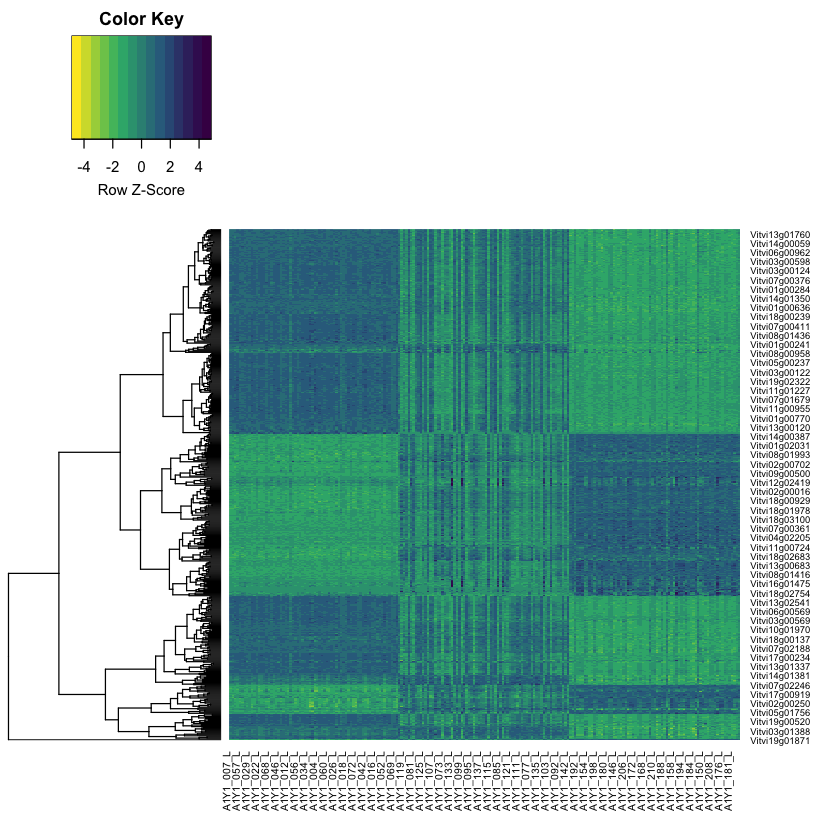

In [8]:
# pdf('2017_geneExpression_heatMap.pdf', width=12, height=12)
gplots::heatmap.2( d, 
                   scale="row", 
                   trace="none", 
                   sepwidth=c(0, 0),
                   dendrogram="row",
                   col = colorRampPalette(rev(viridis(4))),
                   sepcolor = NA,
                   density.info='none', Colv = FALSE,
                   offsetRow = 0, offsetCol = 0
)
# dev.off()

## PCAs

In order to make the gene expression look more like the rest of the paper, and to provide a nice avenue toward data integration, I opted to use the VST-transformed gene expression data to generate principal components. This differs from above in that we now have a gene removed, low counts have been filtered, and the data have been transformed appropriately. 

In [9]:
pca <- prcomp(vsd_counts_t)
x <- summary(pca)
x <- as.data.frame(t(x$importance))
rownames(x) <- paste("PC", 1:212, sep='')

head(x, 20)

Standard deviation Proportion of Variance Cumulative Proportion
PC1  74.424346          0.49031                0.49031              
PC2  29.259441          0.07578                0.56609              
PC3  23.179327          0.04756                0.61365              
PC4  19.266773          0.03286                0.64651              
PC5  16.888055          0.02525                0.67175              
PC6  16.264245          0.02342                0.69517              
PC7  13.439772          0.01599                0.71116              
PC8  12.944185          0.01483                0.72599              
PC9  11.266168          0.01124                0.73722              
PC10 10.799415          0.01032                0.74755              
PC11 10.034549          0.00891                0.75646              
PC12  9.547851          0.00807                0.76453              
PC13  8.917256          0.00704                0.77157              
PC14  8.340414          0.00616                0.77773              
PC15  7.979578          0.00564                0.78336              
PC16  7.630637          0.00515                0.78852              
PC17  7.510089          0.00499                0.79351              
PC18  7.216750          0.00461                0.79812              
PC19  6.804644          0.00410                0.80222              
PC20  6.591804          0.00385                0.80607

In [11]:
pdf("2017_geneExpression_PCAapproach_vstPCA.pdf", onefile=T, height=8, width=8)

for_plot <- data.frame(pca$x)
for_plot$Rootstock <- treatments$Rootstock
p.rootstock <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock)) + 
               geom_point(aes(shape=Rootstock), size=6) + 
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Rootstock', values=rs_palette) + 
               xlab('PC1 (49.0%)') + ylab('PC2 (7.6%)') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))       
p.rootstock

for_plot$Phenology <- treatments$Phenology  
p.phenology <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology)) + 
               geom_point(aes(shape=Phenology), size=6) + 
               scale_shape_manual(values=c(21, 21, 21)) + 
               scale_fill_manual('Phenology', values=p_palette) + 
               xlab('PC1 (49.0%)') + ylab('PC2 (7.6%)') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
p.phenology

for_plot$Irrigation <- treatments$Irrigation  
p.irrigation <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Irrigation)) + 
               geom_point(aes(shape=Irrigation), size=6) + 
               scale_shape_manual(values=c(21, 21, 21)) + 
               scale_fill_manual('Irrigation', values=i_palette) + 
               xlab('PC1 (49.0%)') + ylab('PC2 (7.6%)') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
p.irrigation

for_plot$Row <- treatments$Row  
p.block <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row)) + 
               geom_point(aes(shape=Row), size=6) + 
               scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
               scale_fill_manual('Row', values=row_palette) + 
               xlab('PC1 (49.0%)') + ylab('PC2 (7.6%)') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
p.block

dev.off()

pdf 
  2

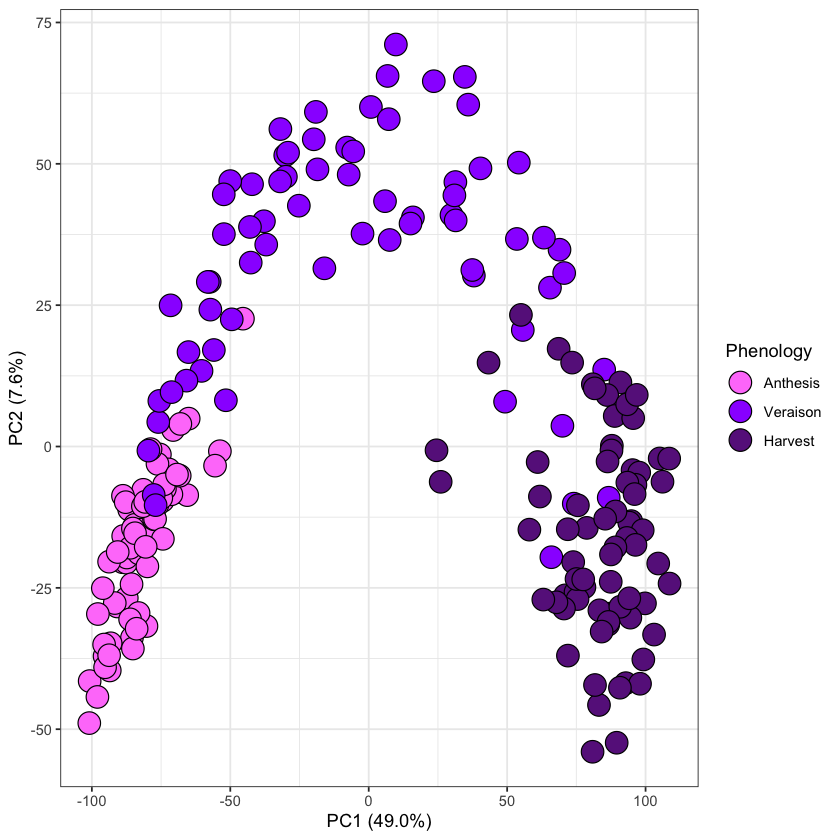

In [12]:
#damn boi look at that 
p.phenology
#p.block

## Linear Models to the Experimental Design

In [13]:
df <- as.data.frame(pca$x) %>% dplyr::select(PC1:PC100)
df$sampleName <- rownames(df)
df <- merge(df, treatments, on='sampleName', how='left')
colnames(df)

[1] "sampleName" "PC1"        "PC2"        "PC3"        "PC4"       
  [6] "PC5"        "PC6"        "PC7"        "PC8"        "PC9"       
 [11] "PC10"       "PC11"       "PC12"       "PC13"       "PC14"      
 [16] "PC15"       "PC16"       "PC17"       "PC18"       "PC19"      
 [21] "PC20"       "PC21"       "PC22"       "PC23"       "PC24"      
 [26] "PC25"       "PC26"       "PC27"       "PC28"       "PC29"      
 [31] "PC30"       "PC31"       "PC32"       "PC33"       "PC34"      
 [36] "PC35"       "PC36"       "PC37"       "PC38"       "PC39"      
 [41] "PC40"       "PC41"       "PC42"       "PC43"       "PC44"      
 [46] "PC45"       "PC46"       "PC47"       "PC48"       "PC49"      
 [51] "PC50"       "PC51"       "PC52"       "PC53"       "PC54"      
 [56] "PC55"       "PC56"       "PC57"       "PC58"       "PC59"      
 [61] "PC60"       "PC61"       "PC62"       "PC63"       "PC64"      
 [66] "PC65"       "PC66"       "PC67"       "PC68"       "PC69"      
 [71] "PC70"       "PC71"       "PC72"       "PC73"       "PC74"      
 [76] "PC75"       "PC76"       "PC77"       "PC78"       "PC79"      
 [81] "PC80"       "PC81"       "PC82"       "PC83"       "PC84"      
 [86] "PC85"       "PC86"       "PC87"       "PC88"       "PC89"      
 [91] "PC90"       "PC91"       "PC92"       "PC93"       "PC94"      
 [96] "PC95"       "PC96"       "PC97"       "PC98"       "PC99"      
[101] "PC100"      "fileName"   "Row"        "Rootstock"  "Irrigation"
[106] "Phenology"  "Tissue"     "Block"      "group"


CAN I NEST ROW WITHIN IRRIGATION?

FIT MODEL WITH IRRIGATION AND THEN MODEL RESIDUALS?


### Test modelling after irrigation residuals

This is an experimental section. For this section, I removed the variation that was associated with irrigation (very little) so that I could fit a model with Row as a factor (row and irrigation are collinear). This allows me to more finely look at the circadian topology of the gene expression space (moreso than just using block). 

In [14]:
## modelling irrigation residuals 

vars <- paste("PC", 1:100, sep='')

# create a collector for models and anovas
models <- list(rep(0, length(vars)))
anovas <- list(rep(0, length(vars)))

# set the appropriate contrasts for type3 SS

oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

for (idx in 1:length(vars)){
    # get variable name at index
    PC <- vars[idx]
    
    # get data
    d <- df %>% dplyr::select(PC, Row:Block)
    colnames(d) <- c('PC', 'Row', 'Rootstock', 'Irrigation', 'Phenology', 'Tissue', 'Block')
    
    #fit lm with only irrigation + grab residuals
    lmod.irr <- lm(PC ~ Irrigation, data=d)
    d$resid <- lmod.irr$residuals
    
    # fit lms
    model <- lm(resid ~Row + Rootstock + Phenology + Row:Rootstock + Row:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    anovas[[idx]] <- stats
    
}

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [23]:
#old
# vars <- paste("PC", 1:100, sep='')

# # create a collector for models and anovas
# models <- list(rep(0, length(vars)))
# anovas <- list(rep(0, length(vars)))

# # set the appropriate contrasts for type3 SS

# oldc <- getOption("contrasts")
# options(contrasts=c('contr.sum','contr.poly'))

# for (idx in 1:length(vars)){
#     # get variable name at index
#     PC <- vars[idx]
    
#     # get data
#     d <- df %>% dplyr::select(PC, Row:Block)
    
#     # fit lms
#     colnames(d) <- c('PC', 'Row', 'Rootstock', 'Irrigation', 'Phenology', 'Tissue', 'Block')
#     model <- lm(PC ~Row + Rootstock + Phenology + Row:Rootstock + Row:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
#     models[[idx]] <- model
    
#     # compute stats on model under type-3 SS
#     stats <- car::Anova(model, type=3)
#     anovas[[idx]] <- stats
    
# }

# # reset base contrasts so nothing is too broken
# options(contrasts = oldc)

In [15]:
factors <- rownames(anovas[[1]])[2:length(rownames(anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$variable <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_geneExpression_PCAapproach_var_p.csv', quote=F)

Row       Rootstock Phenology  Row:Rootstock Row:Phenology
PC1  1.307614 0.2063515 82.3909368  1.498415      0.7104181   
PC2  3.305694 0.9394043 61.3782117  3.869115      5.6384325   
PC3  5.856384 0.7810707  0.9906725 12.200940     30.4180316   
PC4 35.969707 0.8580110  6.5970811  6.123252      9.9166276   
PC5  6.250184 1.5896408  4.8205818 10.188370     10.1516922   
PC6 43.250795 0.6959732  0.8658315  6.070513      6.1852474   
    Rootstock:Phenology Residuals Row_p        Rootstock_p Phenology_p 
PC1 0.2766233           13.60964  7.630281e-02 0.5135091   3.307761e-65
PC2 0.1173796           24.75176  1.274709e-02 0.1282272   6.955663e-42
PC3 2.1106051           47.64230  2.149152e-02 0.4789433   2.092689e-01
PC4 1.9606784           38.57464  1.668461e-18 0.3400861   6.152886e-06
PC5 0.7896623           66.20987  8.232954e-02 0.3057682   4.790049e-03
PC6 0.7131737           42.21847  5.595738e-20 0.4764780   2.137671e-01
    Row:Rootstock_p Row:Phenology_p Rootstock:Phenology_p Residuals_p
PC1 0.84866167      9.462801e-01    0.7963857             NA         
PC2 0.48270815      8.365092e-03    0.9938543             NA         
PC3 0.04292067      3.317916e-10    0.3519631             NA         
PC4 0.46311149      2.601651e-03    0.2661409             NA         
PC5 0.50270883      1.231290e-01    0.9350096             NA         
PC6 0.58749544      1.525204e-01    0.8594643             NA

Row       Rootstock Phenology  Row.Rootstock Row.Phenology
PC1  1.307614 0.2063515 82.3909368  1.498415      0.7104181   
PC2  3.305694 0.9394043 61.3782117  3.869115      5.6384325   
PC3  5.856384 0.7810707  0.9906725 12.200940     30.4180316   
PC4 35.969707 0.8580110  6.5970811  6.123252      9.9166276   
PC5  6.250184 1.5896408  4.8205818 10.188370     10.1516922   
PC6 43.250795 0.6959732  0.8658315  6.070513      6.1852474   
    Rootstock.Phenology Row_p        Rootstock_p Phenology_p  Row.Rootstock_p
PC1 0.2766233           7.630281e-02 0.5135091   3.307761e-65 0.84866167     
PC2 0.1173796           1.274709e-02 0.1282272   6.955663e-42 0.48270815     
PC3 2.1106051           2.149152e-02 0.4789433   2.092689e-01 0.04292067     
PC4 1.9606784           1.668461e-18 0.3400861   6.152886e-06 0.46311149     
PC5 0.7896623           8.232954e-02 0.3057682   4.790049e-03 0.50270883     
PC6 0.7131737           5.595738e-20 0.4764780   2.137671e-01 0.58749544     
    Row.Phenology_p Rootstock.Phenology_p variable
PC1 9.462801e-01    0.7963857             PC1     
PC2 8.365092e-03    0.9938543             PC2     
PC3 3.317916e-10    0.3519631             PC3     
PC4 2.601651e-03    0.2661409             PC4     
PC5 1.231290e-01    0.9350096             PC5     
PC6 1.525204e-01    0.8594643             PC6

variable factor var      
1 PC01     Row     1.307614
2 PC02     Row     3.305694
3 PC03     Row     5.856384
4 PC04     Row    35.969707
5 PC05     Row     6.250184
6 PC06     Row    43.250795

pdf 
  2

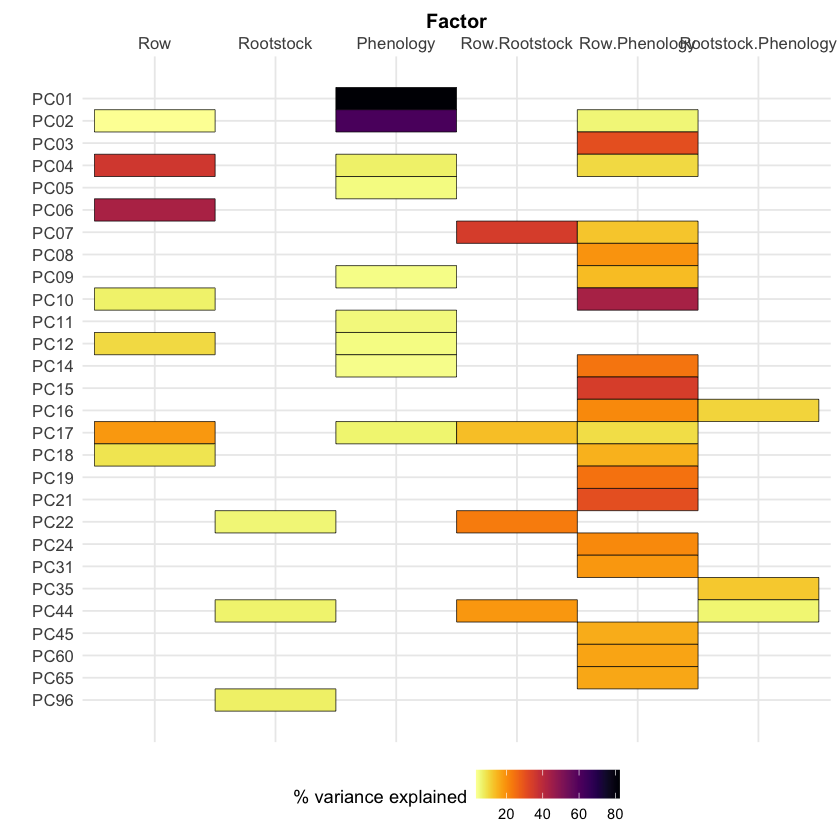

In [16]:
total_var_mat_p$variable <- c('PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC06', 'PC07', 'PC08', 'PC09', 'PC10',
                               paste('PC', 11:100, sep=''))

# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(variable, Row:Rootstock.Phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -variable)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(Row_p:Rootstock.Phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$variable <- total_var_mat_p$variable

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -variable)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("variable", "factor"))

#elements need a number for y-axis when plotting, there are 20 elements here 
total_var_p <- total_var_p %>% arrange(variable) %>% mutate(var_number=rep(1:100, each=length(unique(total_var_p$factor))))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("variable", "factor","var", "p_value")], "2017_geneExpression_PCAapproach_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

var_number_fix <- rep(0, dim(total_var_p_sig)[1])
unique_variable_names <- unique(total_var_p_sig$variable)
for (idx in 1:length(var_number_fix)){
    var_number_fix[idx] <- which(unique_variable_names == total_var_p_sig$variable[[idx]])
}

total_var_p_sig$var_number <- var_number_fix
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('Row', 'Irrigation', 'Rootstock', 'Phenology', 'Row.Rootstock', 'Row.Phenology', 'Rootstock.Phenology'))
# total_var_p_sig$variable <- factor(total_var_p_sig$variable, levels=c('PC1', 'PC2','PC3','PC4','PC5','PC6','PC7',
#                                                                       'PC8','PC9','PC10', 'PC11', 'PC12', 'PC13', 
#                                                                       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'))
# total_var_p_sig$var_number <- factor(total_var_p_sig$var_number, levels=c('1', '8', '9', '10', '11','12','13', '2','3','4','5','6','7'))


#make plot
t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(var_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="") + 
    theme(axis.text=element_text(size=10),axis.title=element_text(size=12,face="bold"),legend.position = "bottom") +
    scale_y_continuous(trans="reverse", breaks = 1:length(unique(total_var_p_sig$variable)), minor_breaks=NULL, labels=unique(total_var_p_sig[,"variable"])) +
    scale_x_discrete(position = "top") + 
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)
t

pdf("geneExpression_PCAapproach_variance_heatmap_black_viridis.pdf", width=6, height=6)
  t
dev.off()

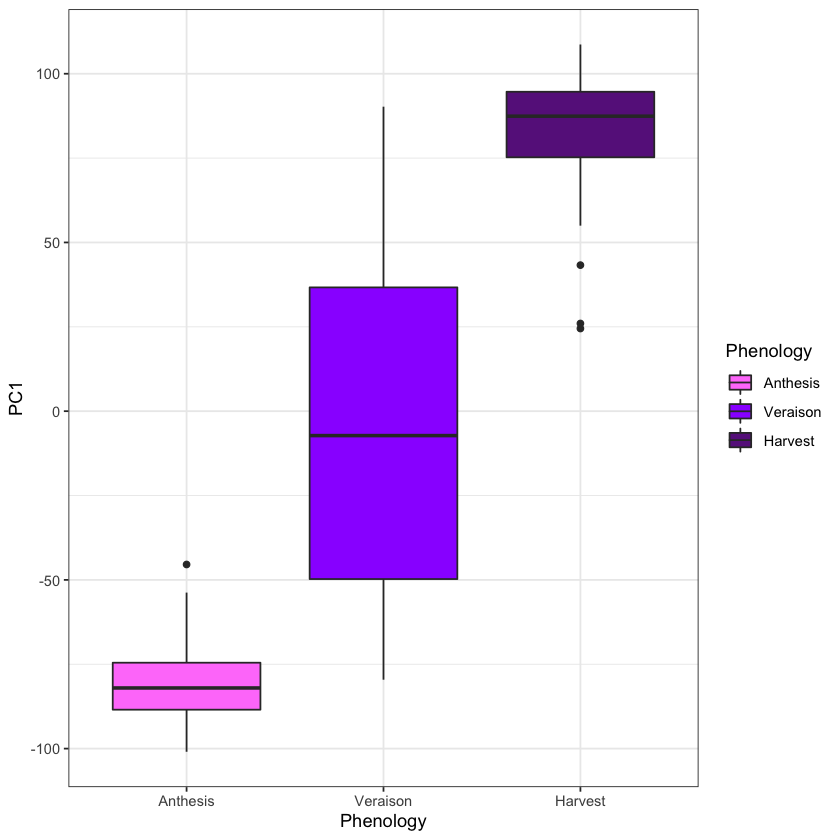

In [17]:
p <- ggplot(df, aes(y=PC1, x=Phenology, fill=Phenology)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Phenology', values=p_palette) + 
     theme_bw()
p

In [18]:
d <- df %>% dplyr::select(PC1, Row:Block)

emm <- emmeans(models[[1]], ~Phenology)
res <- pairs(emm)
res <- as.data.frame(res)
res[res$p.value < 0.05,]

NOTE: Results may be misleading due to involvement in interactions


contrast            estimate   SE       df  t.ratio   p.value
1 Anthesis - Veraison  -78.23733 5.457019 152 -14.33701 0      
2 Anthesis - Harvest  -165.42578 5.457019 152 -30.31431 0      
3 Veraison - Harvest   -87.18845 5.432231 152 -16.05021 0

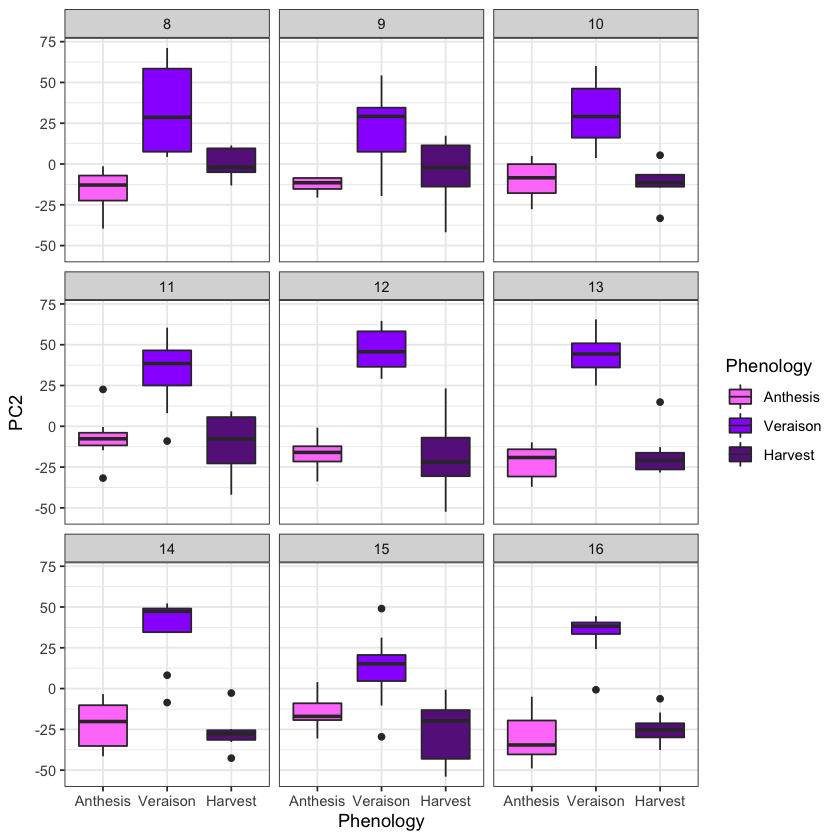

In [19]:
p <- ggplot(df, aes(y=PC2, x=Phenology, fill=Phenology)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Phenology', values=p_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

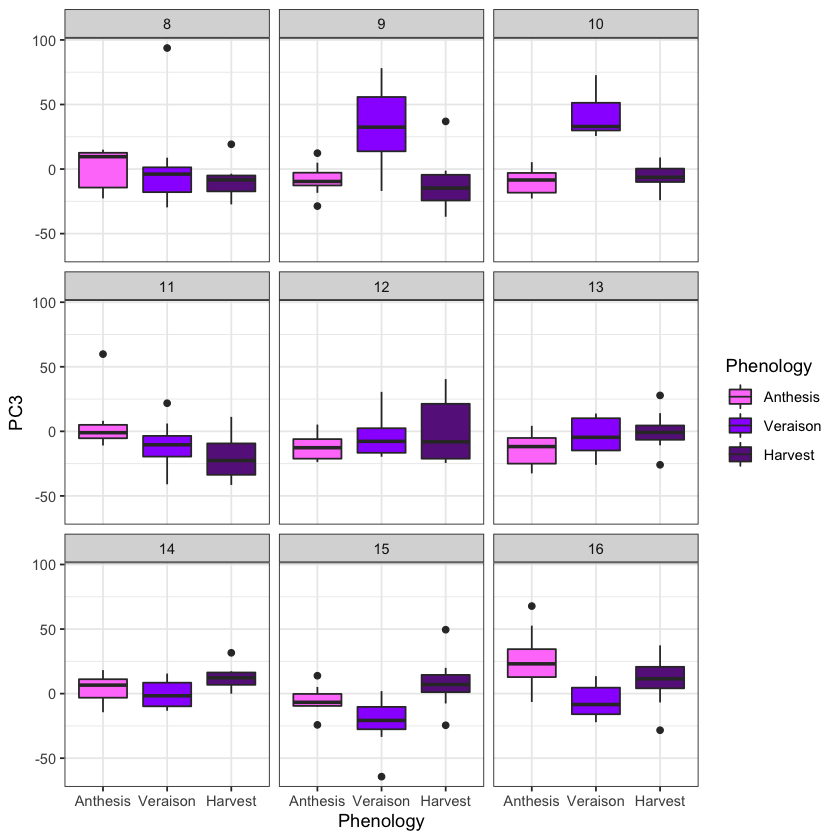

In [20]:
p <- ggplot(df, aes(y=PC3, x=Phenology, fill=Phenology)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Phenology', values=p_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

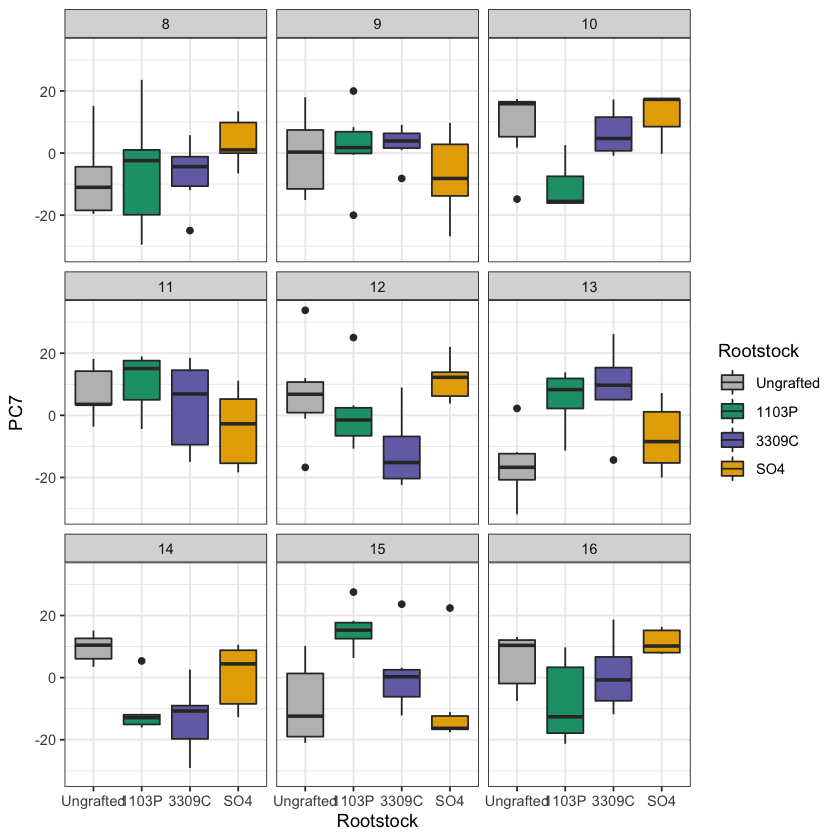

In [21]:
p <- ggplot(df, aes(y=PC7, x=Rootstock, fill=Rootstock)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=rs_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

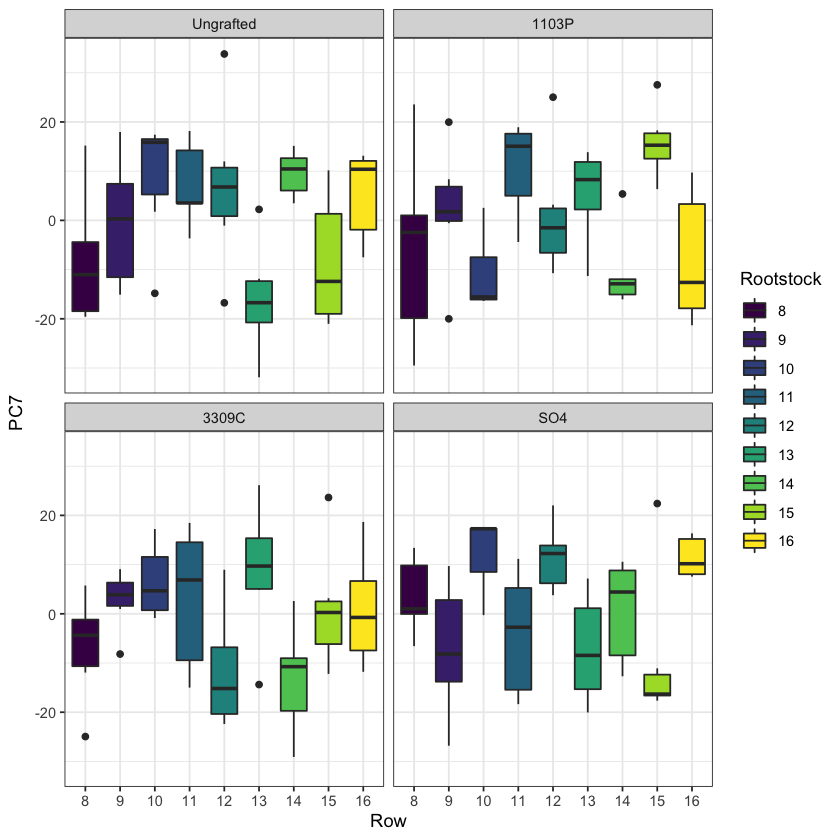

In [22]:
p <- ggplot(df, aes(y=PC7, x=Row, fill=Row)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=row_palette) + 
     facet_wrap('Rootstock') + 
     theme_bw()
p

In [23]:
# hmmmmm

d <- df %>% dplyr::select(PC7, Row:Block)

emm <- emmeans(models[[7]], ~Rootstock|Row)
res <- pairs(emm)
res <- as.data.frame(res)
res[res$p.value < 0.05,]

# from emmeans: 
# Results are averaged over the levels of: Phenology 
# P value adjustment: tukey method for comparing a family of 4 estimates

contrast          Row estimate  SE      df  t.ratio   p.value     
13 Ungrafted - 1103P 10   19.80213 6.24517 152  3.170791 0.0098427342
16 1103P - 3309C     10  -17.50301 6.24517 152 -2.802648 0.0289672574
17 1103P - SO4       10  -22.44277 7.64874 152 -2.934179 0.0199809381
26 Ungrafted - 3309C 12   18.57248 6.24517 152  2.973895 0.0178049337
30 3309C - SO4       12  -23.13646 6.24517 152 -3.704696 0.0016680893
31 Ungrafted - 1103P 13  -21.40933 6.24517 152 -3.428143 0.0043092978
32 Ungrafted - 3309C 13  -24.66491 6.24517 152 -3.949438 0.0006848203
37 Ungrafted - 1103P 14   20.23014 6.24517 152  3.239327 0.0079433732
38 Ungrafted - 3309C 14   22.76991 6.24517 152  3.646004 0.0020508555
43 Ungrafted - 1103P 15  -24.25253 6.24517 152 -3.883407 0.0008746855
47 1103P - SO4       15   25.03480 6.24517 152  4.008666 0.0005483334
53 1103P - SO4       16  -19.37784 6.24517 152 -3.102853 0.0121239427

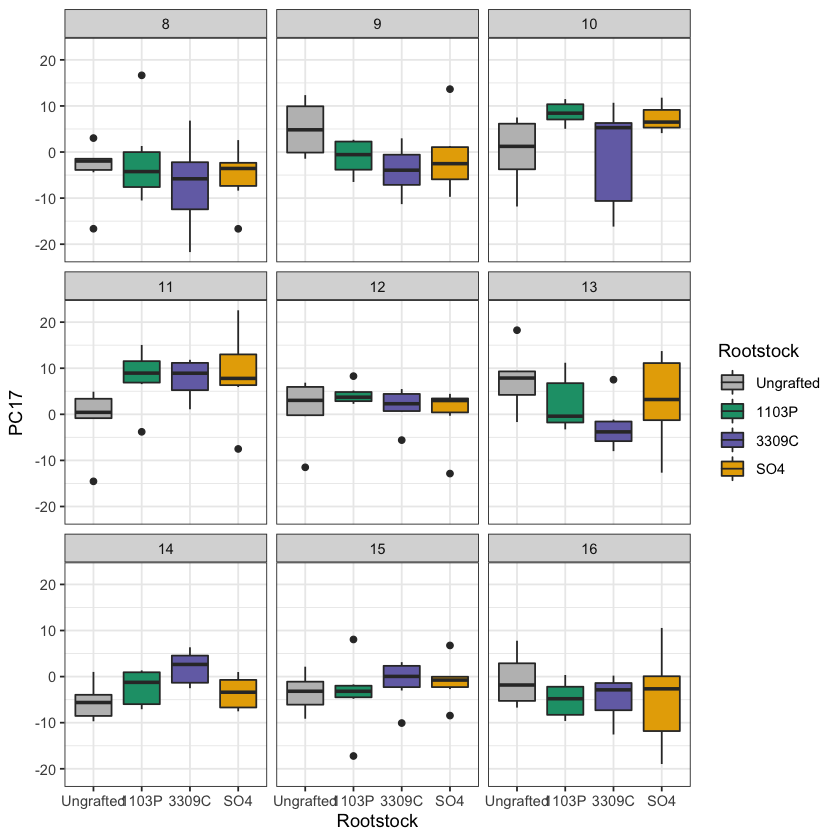

In [24]:
p <- ggplot(df, aes(y=PC17, x=Rootstock, fill=Rootstock)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=rs_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

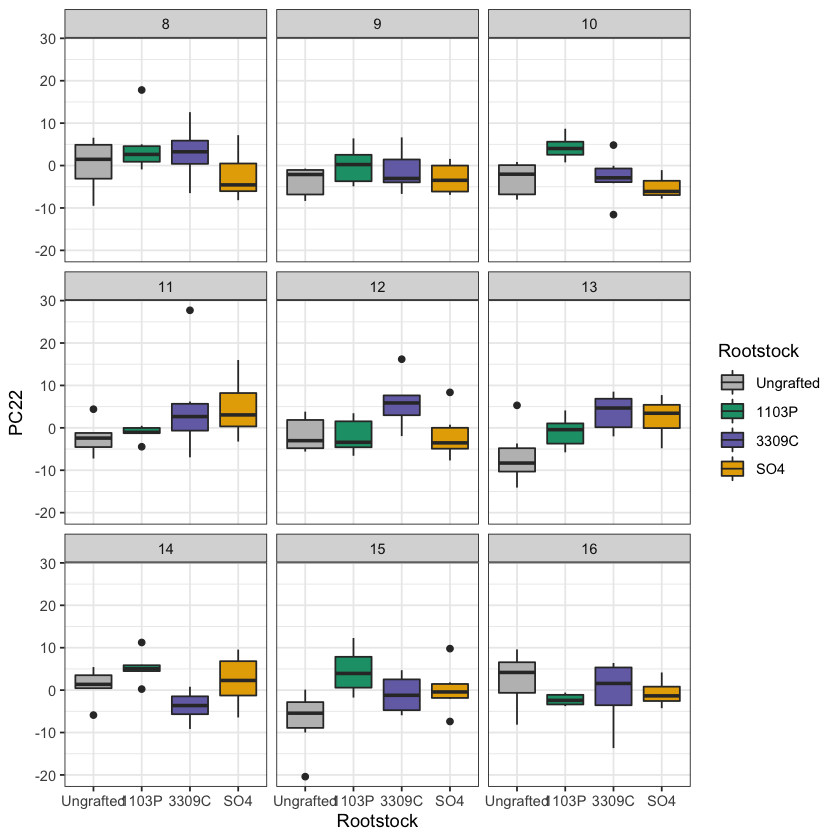

In [25]:
p <- ggplot(df, aes(y=PC22, x=Rootstock, fill=Rootstock)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=rs_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

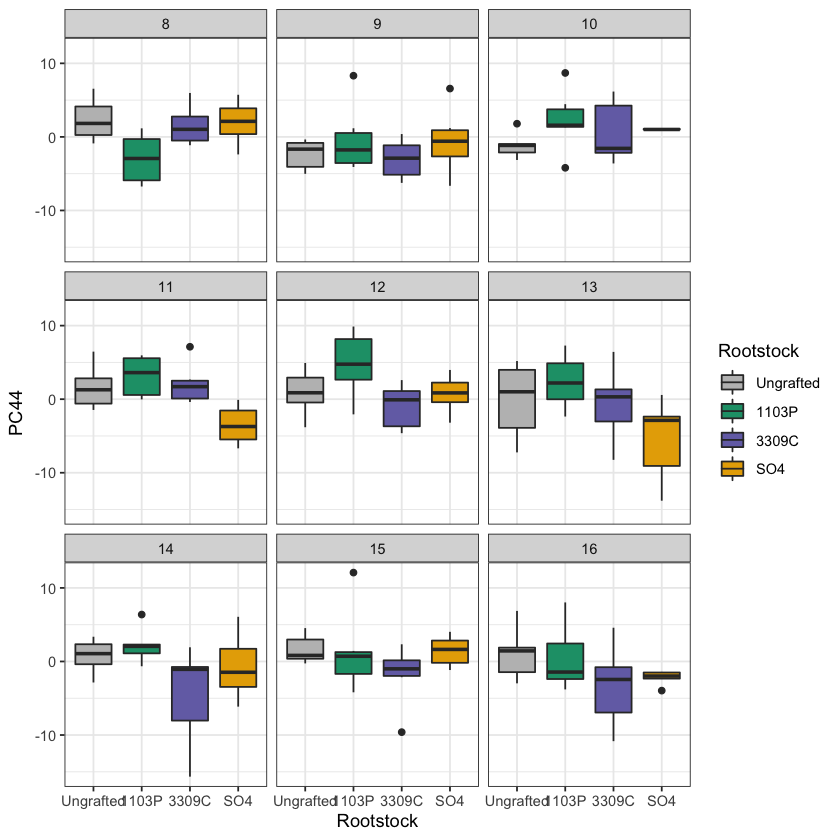

In [26]:
p <- ggplot(df, aes(y=PC44, x=Rootstock, fill=Rootstock)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=rs_palette) + 
     facet_wrap('Row') + 
     theme_bw()
p

[1] -0.01617252  0.01726869


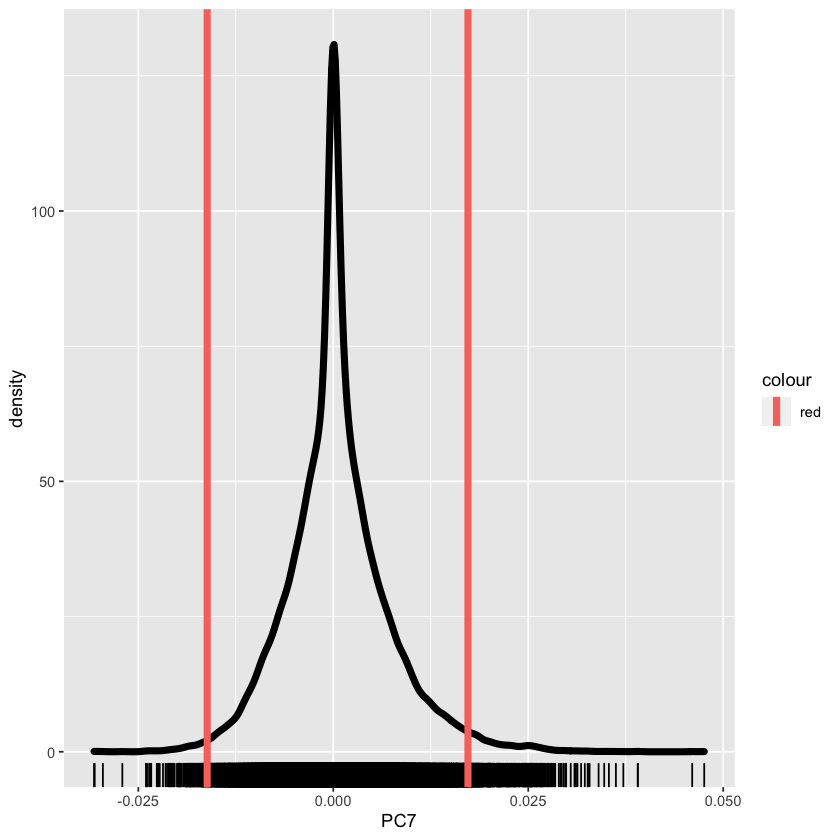

In [27]:
x <- as.data.frame(pca$rotation)

m <- mean(x$PC7)
s <- sd(x$PC7)

us <- m + (s * 2.57)
ls <- m - (s * 2.57)

print(c(ls, us))

p <- ggplot(x, aes(x=PC7)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

In [28]:
us.genes <- rownames(x[x$PC7 < ls,])
ls.genes <- rownames(x[x$PC7 > us,])

us.df <- vsd_counts_t[,which(colnames(vsd_counts_t) %in% us.genes)]
ls.df <- vsd_counts_t[,which(colnames(vsd_counts_t) %in% ls.genes)]

dim(us.df)
dim(ls.df)

[1] 212 134

[1] 212 411

In [29]:
PC7.highlow.df <- cbind(us.df, ls.df)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     12.744 9.1367 7.2672 6.22414 5.07504 4.30382 3.99314
Proportion of Variance  0.298 0.1532 0.0969 0.07108 0.04726 0.03399 0.02926
Cumulative Proportion   0.298 0.4512 0.5481 0.61917 0.66643 0.70042 0.72968
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     3.67517 3.18327 2.85372 2.79046 2.40163 2.30059 2.23647
Proportion of Variance 0.02478 0.01859 0.01494 0.01429 0.01058 0.00971 0.00918
Cumulative Proportion  0.75446 0.77305 0.78800 0.80228 0.81287 0.82258 0.83176
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     2.1518 1.89036 1.85468 1.78494 1.74347 1.61866 1.53873
Proportion of Variance 0.0085 0.00656 0.00631 0.00585 0.00558 0.00481 0.00434
Cumulative Proportion  0.8403 0.84681 0.85312 0.85897 0.86454 0.86935 0.87370
                          PC22    PC23    

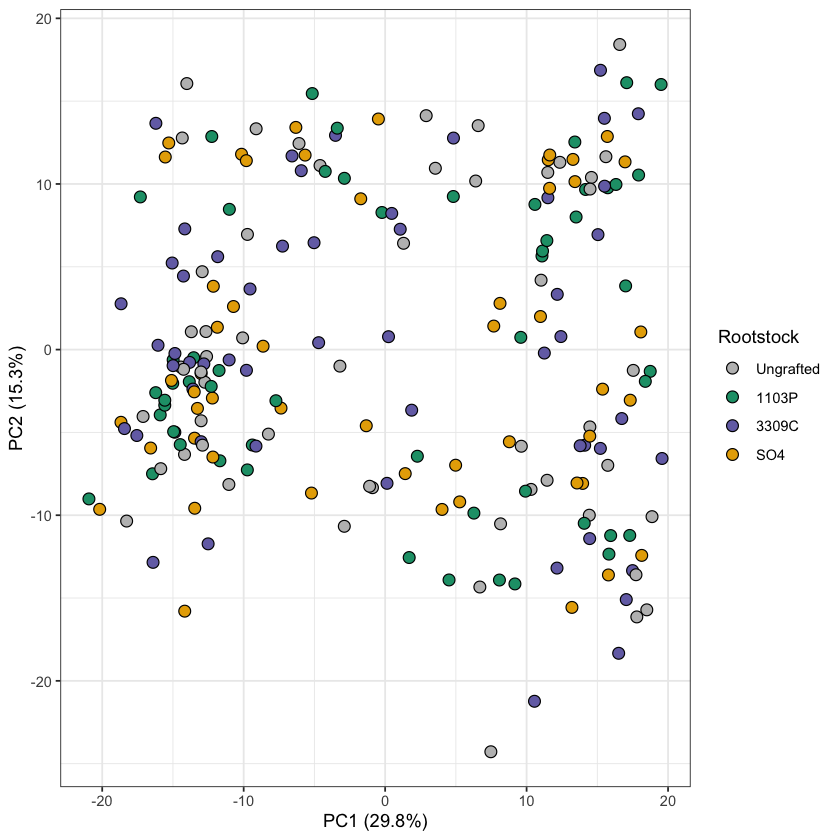

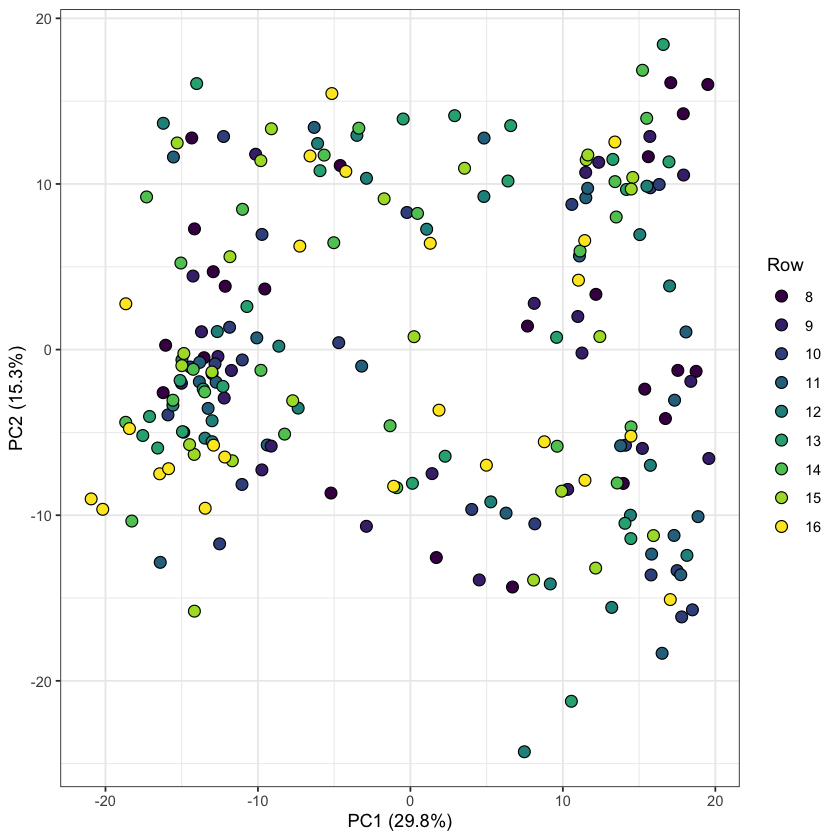

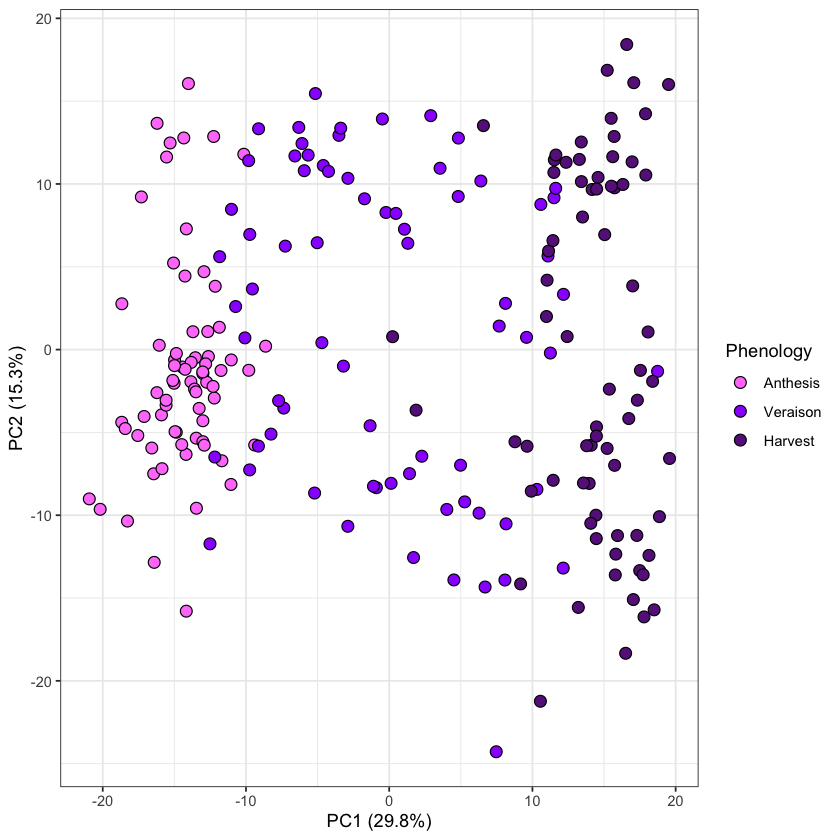

In [23]:
# pca.PC7 <- prcomp(PC7.highlow.df, center=T, scale=T)
# summary(pca.PC7)

# for_plot <- data.frame(pca.PC7$x)
# for_plot$Rootstock <- treatments$Rootstock
# p.rootstock <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock)) + 
#                geom_point(aes(shape=Rootstock), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21)) + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('PC1 (29.8%)') + ylab('PC2 (15.3%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))       
# p.rootstock

# for_plot$Row <- treatments$Row  
# p.row <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row)) + 
#                geom_point(aes(shape=Row), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
#                scale_fill_manual('Row', values=row_palette) + 
#                xlab('PC1 (29.8%)') + ylab('PC2 (15.3%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.row

# for_plot$Phenology <- treatments$Phenology  
# p.phenology <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology)) + 
#                geom_point(aes(shape=Phenology), size=3) + 
#                scale_shape_manual(values=c(21, 21, 21)) + 
#                scale_fill_manual('Phenology', values=p_palette) + 
#                xlab('PC1 (29.8%)') + ylab('PC2 (15.3%)') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p.phenology

## Make all possible box plots

This is to visualize all of the tiles in the tile plot, if interested. At some point, I need to add in some of the linear models that I will discuss in the paper. 

In [117]:
pdf("2017_geneExpression_PCAapproach_pcRow.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Row', fill='Row')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Row', values=row_palette) + 
         theme_bw()
    print(p)
}

dev.off()

pdf 
  2

In [118]:
pdf("2017_geneExpression_PCAapproach_pcRootstock.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Rootstock', fill='Rootstock')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Rootstock', values=rs_palette) + 
         theme_bw()
    print(p)
}

dev.off()

pdf 
  2

In [107]:
pdf("2017_geneExpression_PCAapproach_pcPhenology.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Phenology', fill='Phenology')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Phenology', values=p_palette) + 
         theme_bw()
    print(p)
}

dev.off()

pdf 
  2

In [121]:
pdf("2017_geneExpression_PCAapproach_pcRowRootstock.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Row', fill='Row')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Row', values=row_palette) +
         facet_wrap("Rootstock") + 
         theme_bw()
    print(p)
}
dev.off()

pdf 
  2

In [122]:
pdf("2017_geneExpression_PCAapproach_pcRootstockRow.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Rootstock', fill='Rootstock')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Rootstock', values=rs_palette) +
         facet_wrap("Row") + 
         theme_bw()
    print(p)
}
dev.off()

pdf 
  2

In [108]:
pdf("2017_geneExpression_PCAapproach_pcPhenologyRow.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Row', fill='Row')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Row', values=row_palette) +
         facet_wrap("Phenology") + 
         theme_bw()
    print(p)
}
dev.off()

pdf 
  2

In [120]:
pdf("2017_geneExpression_PCAapproach_pcRootstockPhenology.pdf", onefile=T, height=8, width=8)

for (i in 1:100){
    p <- ggplot(df, aes_string(y=paste("PC", i, sep=''), x='Rootstock', fill='Rootstock')) + 
         geom_boxplot() + 
         scale_fill_manual(name='Row', values=rs_palette) +
         facet_wrap("Phenology") + 
         theme_bw()
    print(p)
}
dev.off()

pdf 
  2

## LDA

In the gene expression module approach, I showed that despite the modules not responding to grafting as discovered through linear models or random forests, there was a signal in the LDA. Here, I explore this a little more deeply. I fit an LDA for each factor in the model, then I pull out the PCs that load heavily onto LD1. Those PCs can be analyzed for their responde in the LMs (tile plots above) and the box plots for each factor. 

In [51]:
d <- as.data.frame(pca$x) %>% dplyr::select(PC1:PC100)

### Phenology

pdf 
  2

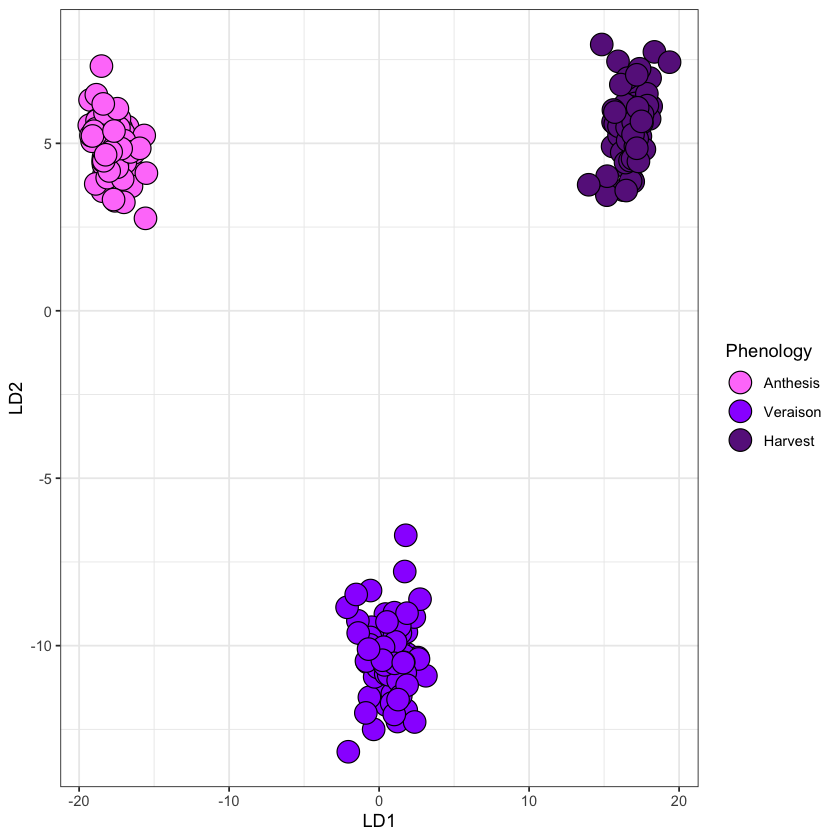

In [74]:
lda.phenology <- lda(d, grouping=df$Phenology)
for_plot <- as.data.frame(predict(lda.phenology, d))
for_plot$Phenology <- df$Phenology

p.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Phenology)) + 
               geom_point(aes(shape=Phenology), size=6) + 
               scale_shape_manual(values=c(21, 21, 21)) + 
               scale_fill_manual('Phenology', values=p_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
p.lda

pdf('2017_geneExpression_lda_phenology.pdf', height=6, width=6)
  p.lda
dev.off()

[1] -0.1435346  0.1414772


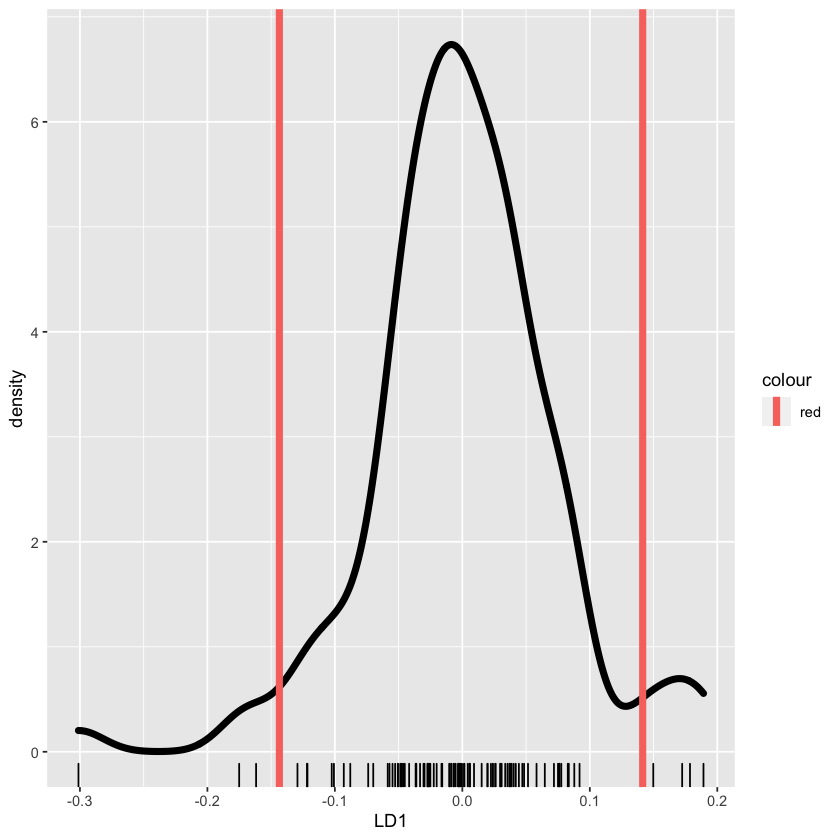

In [56]:
x <- as.data.frame(lda.phenology$scaling)

m <- mean(x$LD1)
s <- sd(x$LD1)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

print(c(ls, us))

p <- ggplot(x, aes(x=LD1)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

This shows the PCs that load more than 1.96 standard deviations from the mean loading (outside the red lines). 

In [57]:
x[x$LD1 < ls,]
x[x$LD1 > us,]

LD1        LD2       
PC10 -0.1750756 -0.0503430
PC17 -0.3011333  0.1764610
PC28 -0.1617964 -0.1059158

LD1       LD2        
PC1  0.1724498  0.00625767
PC4  0.1785877  0.02505185
PC36 0.1891688  0.06159888
PC40 0.1497843 -0.02314077

In [58]:
# PC2 but no plot

x <- as.data.frame(lda.phenology$scaling)
m <- mean(x$LD2)
s <- sd(x$LD2)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

x[x$LD2 < ls,]
x[x$LD2 > us,]

LD1         LD2       
PC2   0.02243709 -0.1998851
PC12  0.05151067 -0.1651504
PC14 -0.05716090 -0.1793416
PC22  0.04192926 -0.1285583

LD1          LD2      
PC9  -0.008513143 0.1411370
PC11 -0.027291138 0.1675592
PC17 -0.301133323 0.1764610
PC29  0.091936446 0.1290734
PC55  0.036906445 0.1540686

### Rootstock

pdf 
  2

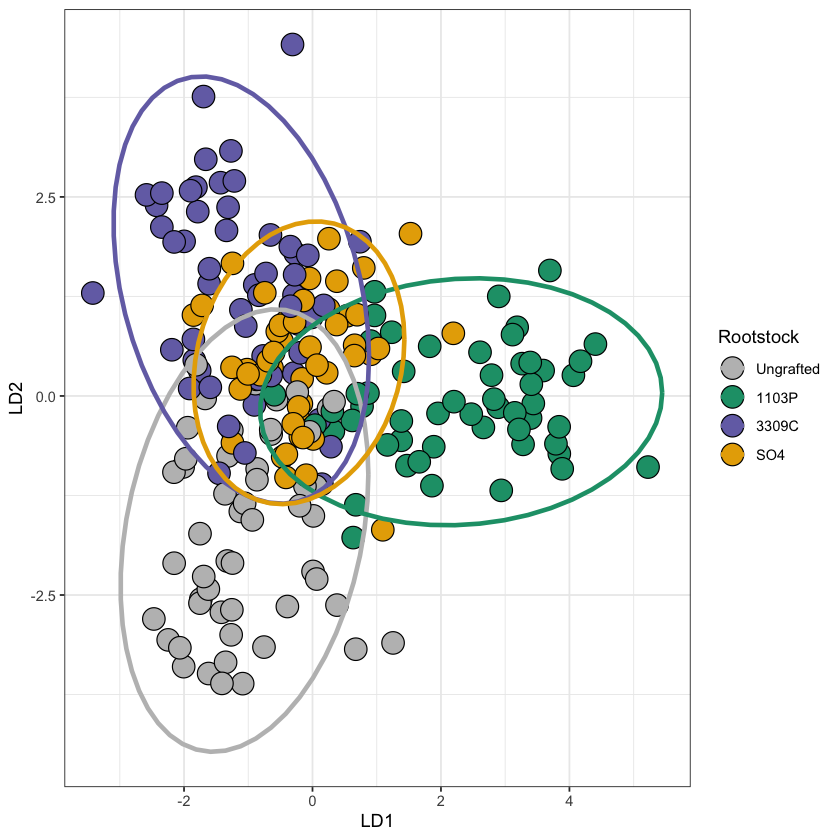

In [59]:
lda.rootstock <- lda(d, grouping=df$Rootstock)
for_plot <- as.data.frame(predict(lda.rootstock, d))
for_plot$Rootstock <- df$Rootstock

rs.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Rootstock)) + 
               geom_point(aes(shape=Rootstock), size=6) + 
               stat_ellipse(aes(color=Rootstock), lwd=1.3) + scale_color_manual('Rootstock', values=rs_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Rootstock', values=rs_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
rs.lda

pdf('2017_geneExpression_lda_rootstock.pdf', height=6, width=6)
  rs.lda
dev.off()

[1] -0.07784413  0.08212306


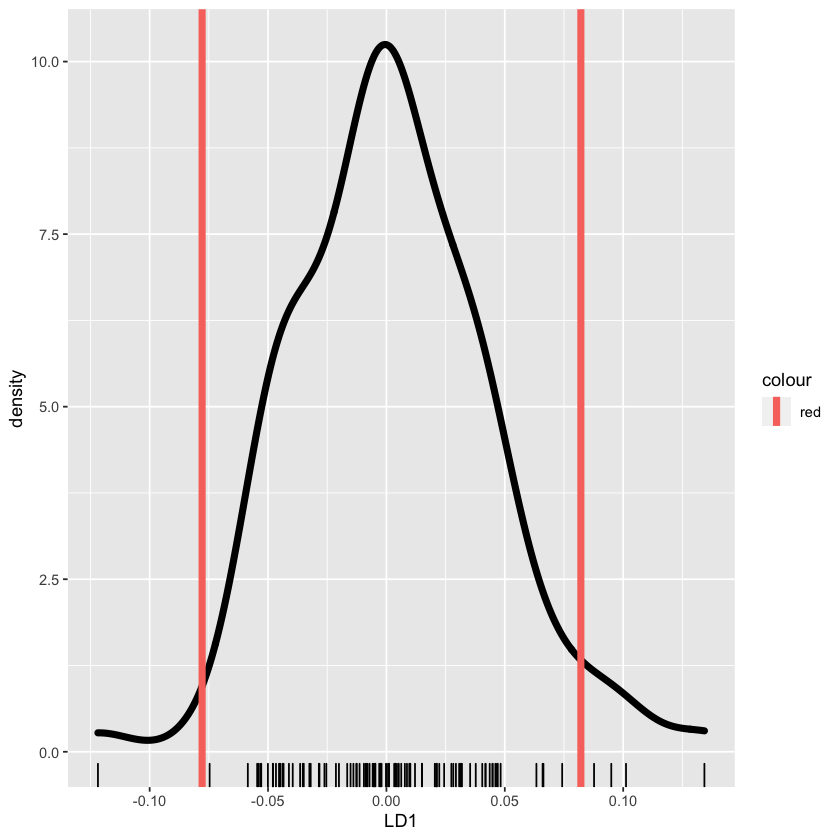

In [69]:
x <- as.data.frame(lda.rootstock$scaling)

m <- mean(x$LD1)
s <- sd(x$LD1)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

print(c(ls, us))

p <- ggplot(x, aes(x=LD1)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

In [70]:
x[x$LD1 < ls,]
x[x$LD1 > us,]

LD1        LD2         LD3       
PC81 -0.1218412 -0.01936288 0.04008854

LD1        LD2         LD3         
PC44 0.09497243 -0.07479286 -0.037653045
PC53 0.10119717  0.05666975  0.021729985
PC79 0.13430485 -0.01892187 -0.002431625
PC98 0.08770028 -0.05500718 -0.021787440

In [71]:
# PC2 but no plot

x <- as.data.frame(lda.rootstock$scaling)
m <- mean(x$LD2)
s <- sd(x$LD2)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

x[x$LD2 < ls,]
x[x$LD2 > us,]

LD1         LD2         LD3       
PC83 0.003891226 -0.08777113 0.09389345

LD1          LD2        LD3        
PC93   0.046015303 0.10466064 -0.02798722
PC96   0.031888764 0.08197427  0.13543740
PC100 -0.005364407 0.07117918 -0.02937667

### Irrigation

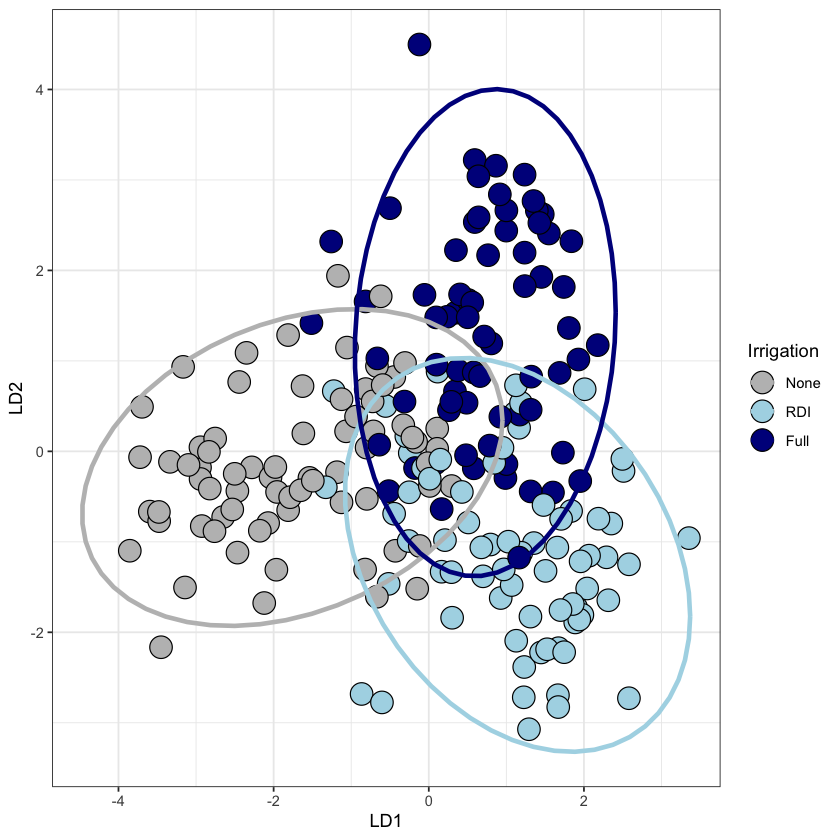

In [37]:
lda.irrigation <- lda(d, grouping=df$Irrigation)
for_plot <- as.data.frame(predict(lda.irrigation, d))
for_plot$Irrigation <- df$Irrigation

i.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Irrigation)) + 
               geom_point(aes(shape=Irrigation), size=6) + 
               stat_ellipse(aes(color=Irrigation), lwd=1.3) + scale_color_manual('Irrigation', values=i_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Irrigation', values=i_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
i.lda

[1] -0.07051110  0.07210526


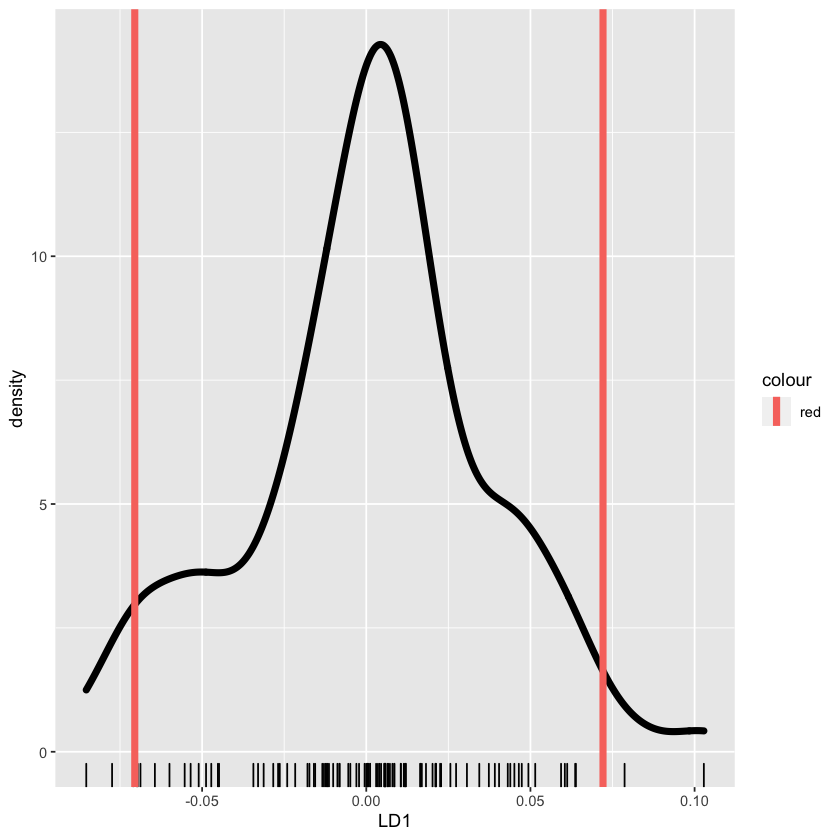

In [38]:
x <- as.data.frame(lda.irrigation$scaling)

m <- mean(x$LD1)
s <- sd(x$LD1)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

print(c(ls, us))

p <- ggplot(x, aes(x=LD1)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

In [39]:
rownames(x[x$LD1 < ls,])
rownames(x[x$LD1 > us,])

[1] "PC35" "PC41" "PC99"

[1] "PC73" "PC78"

### Row

pdf 
  2

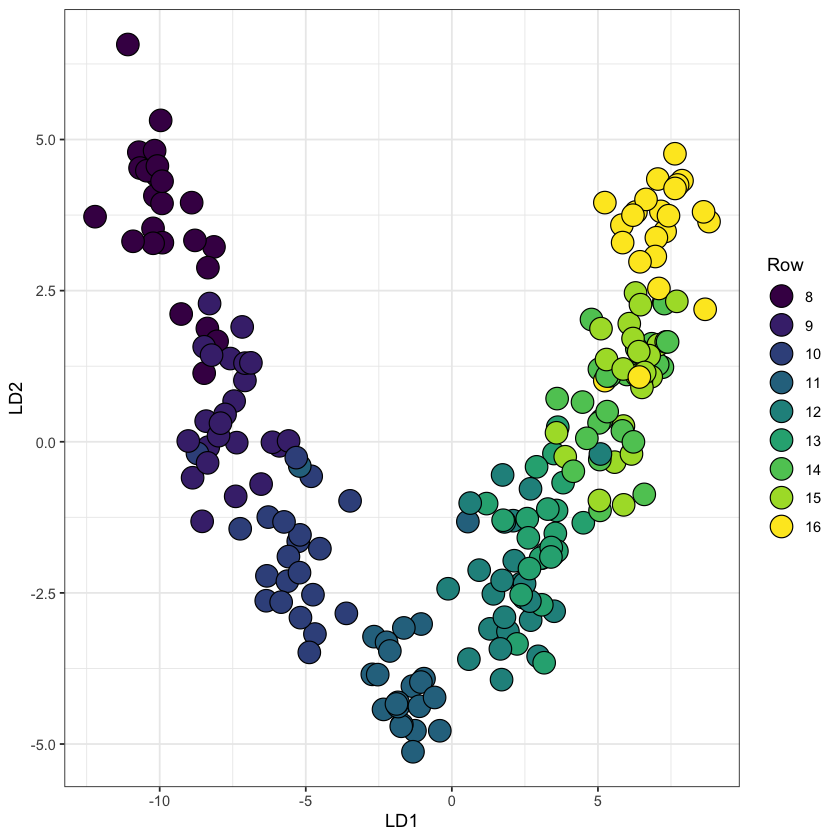

In [76]:
lda.row <- lda(d, grouping=df$Row)
for_plot <- as.data.frame(predict(lda.row, d))
for_plot$Row <- df$Row

r.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Row)) + 
               geom_point(aes(shape=Row), size=6) + 
               #stat_ellipse(aes(color=Row)) + scale_color_manual('Row', values=row_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
               scale_fill_manual('Row', values=row_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
r.lda

pdf('2017_geneExpression_lda_row6.pdf', height=6, width=6)
  r.lda
dev.off()

[1] -0.09477071  0.10635302


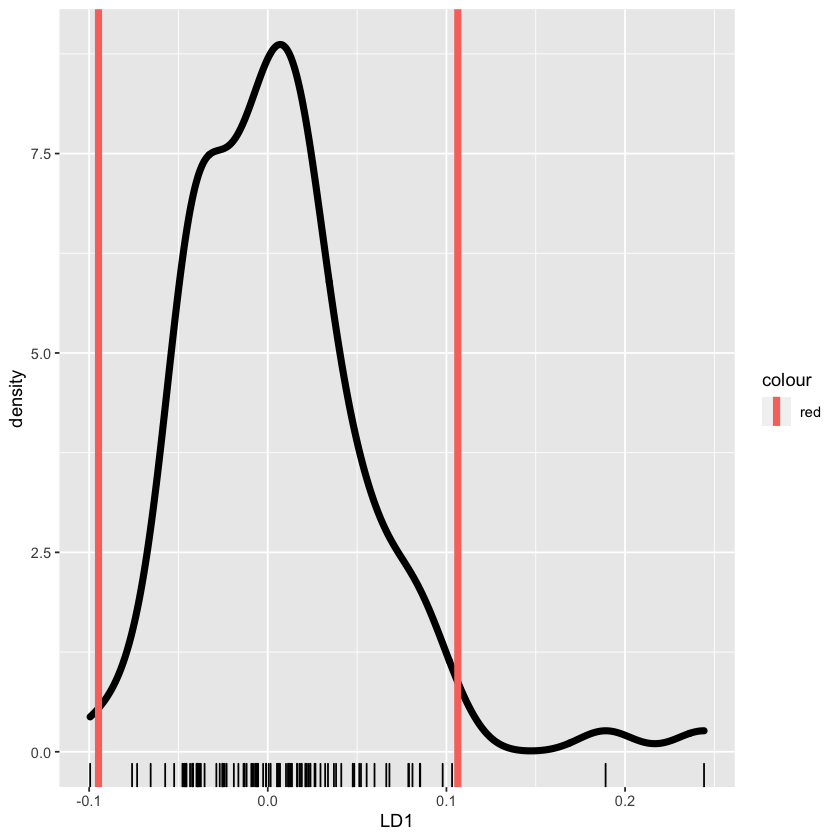

In [72]:
x <- as.data.frame(lda.row$scaling)

m <- mean(x$LD1)
s <- sd(x$LD1)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

print(c(ls, us))

p <- ggplot(x, aes(x=LD1)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

In [65]:
x[x$LD1 < ls,]
x[x$LD1 > us,]

LD1         LD2          LD3          LD4        LD5        LD6        
PC15 -0.09944613 -0.006912377 -0.004681237 0.00677508 0.01290907 0.005547803
     LD7          LD8        
PC15 0.0007971625 -0.01146994

LD1       LD2          LD3          LD4           LD5          LD6         
PC4 0.1891094  0.008800549 -0.010130348  0.0089792179  0.006962329 -0.002162684
PC6 0.2442163 -0.008926818  0.009525466 -0.0003899074 -0.007098084  0.000241908
    LD7          LD8        
PC4  0.000137438  0.01193620
PC6 -0.001166846 -0.01126232

In [73]:
# PC2 but no plot

x <- as.data.frame(lda.row$scaling)
m <- mean(x$LD2)
s <- sd(x$LD2)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

x[x$LD2 < ls,]
x[x$LD2 > us,]

LD1         LD2        LD3        LD4          LD5         LD6         
PC17 -0.04557098 -0.1623255 0.01204071 -0.002707047 -0.01901261  0.009339027
PC62  0.07866779 -0.1017134 0.01466739 -0.055001021  0.04903112  0.048596000
PC78 -0.02525853 -0.1014529 0.13462840  0.027379147 -0.02599981 -0.023944781
     LD7          LD8        
PC17 -0.003398669  0.01363181
PC62 -0.092376028 -0.06419669
PC78  0.005438976  0.02093052

LD1         LD2        LD3         LD4         LD5        LD6       
PC18 -0.06557438 0.10730226 -0.00239356 -0.01054733 0.01820567 0.02825846
PC63 -0.02690301 0.08359537 -0.03670801 -0.01012992 0.01557180 0.03220694
     LD7         LD8         
PC18 -0.01392246  0.003938447
PC63 -0.02867755 -0.035131747

### Row by Phenology

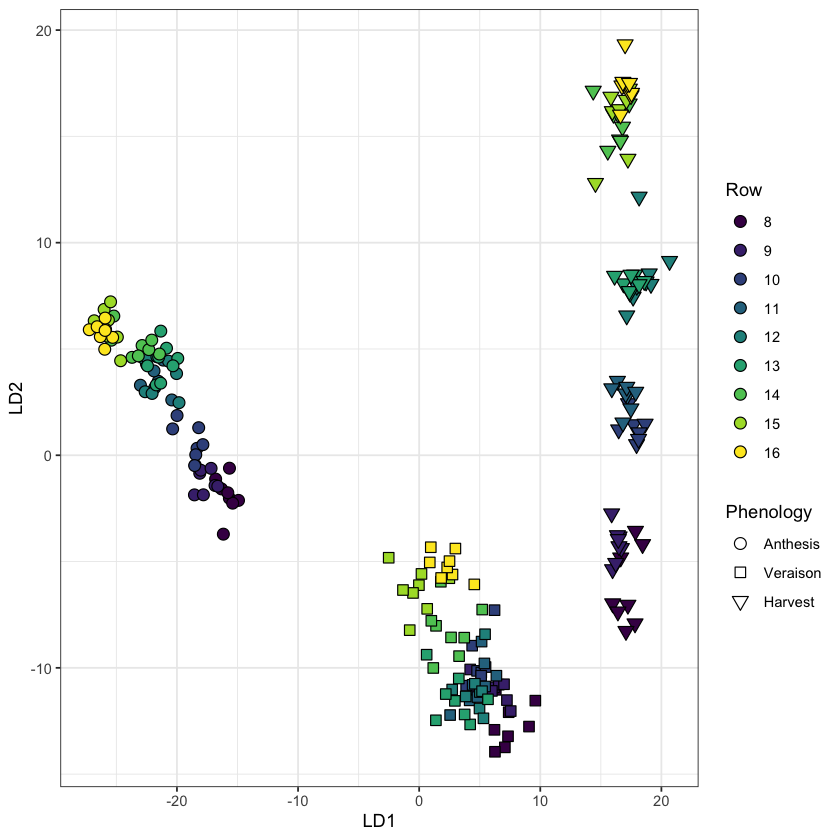

In [43]:
lda.RowPhenology <- lda(d, grouping=paste(df$Row, df$Phenology, sep='_'))
for_plot <- as.data.frame(predict(lda.RowPhenology, d))
for_plot$group <- paste(df$Row, df$Phenology, sep='_')
for_plot$Row <- df$Row
for_plot$Phenology <- df$Phenology

p <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Row, shape=Phenology)) + 
     geom_point(size = 3) + 
     #stat_ellipse(aes(color=Row)) + scale_color_manual('Row', values=row_palette) + 
     scale_fill_manual("Row", values=row_palette) + 
     scale_shape_manual(values=c(21, 22, 25)) +
     xlab('LD1') + ylab('LD2') + theme_bw() + 
     guides(fill = guide_legend(override.aes = list(shape = 21))) 

p

### Row by Rootstock

Too few points to calculate an ellipse
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

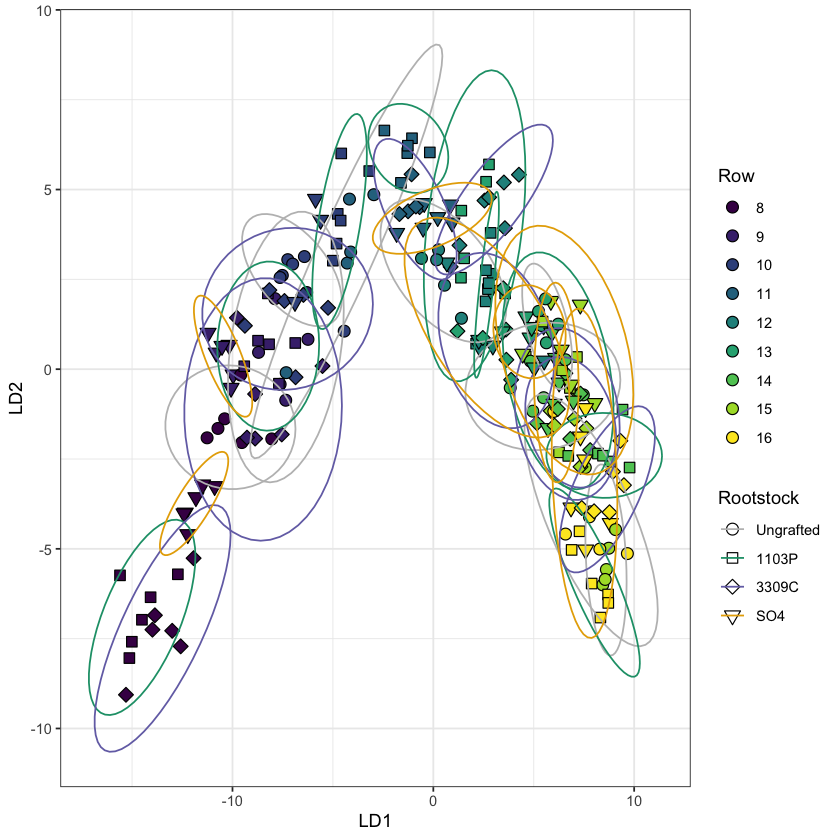

In [44]:
lda.RowRootstock <- lda(d, grouping=paste(df$Row, df$Rootstock, sep='_'))
for_plot <- as.data.frame(predict(lda.RowRootstock, d))
for_plot$group <- paste(df$Row, df$Rootstock, sep='_')
for_plot$Row <- df$Row
for_plot$Rootstock <- df$Rootstock

p <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Row, shape=Rootstock)) + 
     geom_point(size = 3) + 
     stat_ellipse(aes(color=Rootstock)) + scale_color_manual('Rootstock', values=rs_palette) + 
     scale_fill_manual("Row", values=row_palette) + 
     scale_shape_manual(values=c(21, 22, 23, 25)) +
     xlab('LD1') + ylab('LD2') + theme_bw() + 
     guides(fill = guide_legend(override.aes = list(shape = 21))) 

p

## Random Forest

Given the seperability of the LDA analysis, I fit random forests for each of the main effects. I don't fit interactions here because the replication is way too low. 

In [45]:
data <- df %>% dplyr::select(PC1:PC100)

In [46]:
# Get random 80% training/ 20% test indices
shuf_idx <- sample(1:nrow(data))
n <- ceiling(length(shuf_idx) * 0.8)
train_idx <- shuf_idx[1:n]
test_idx <- shuf_idx[(n+1):nrow(data)]

X_train <- data[train_idx, ]
X_test <- data[test_idx,]

#### Phenology

In [47]:
# fit Random Forest for Phenology

# get train test labels
p.labels <- treatments$Phenology
y_train <- p.labels[train_idx]
y_test <- p.labels[test_idx]


pGeneExpressionGrid <- expand.grid(mtry=sample(x=2:100, size=20, replace=F))
pGeneExpressionrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=pGeneExpressionGrid, ntree=100, keep.forest=T, importance=1)

Anthesis    Veraison      Harvest      MeanDecreaseAccuracy
PC1  0.255416040  0.0557953336  0.191943139 0.164860714         
PC2  0.107965290  0.1930186782  0.062762109 0.121835778         
PC4  0.039148121  0.0150194615  0.007281708 0.020731682         
PC9  0.011495176  0.0068435876  0.016139624 0.011027248         
PC17 0.017637320  0.0132478458 -0.001229136 0.010330161         
PC11 0.008909225  0.0067271982  0.011224133 0.008737520         
PC7  0.016212397 -0.0004031014  0.003764299 0.006468893         
PC24 0.016168487  0.0017527778  0.001241406 0.005458941         
PC5  0.012414570 -0.0011728738  0.004446289 0.005355198         
PC12 0.007165043  0.0056783772  0.001299391 0.005033622         
     MeanDecreaseGini
PC1  25.723523       
PC2  18.893053       
PC4   3.603853       
PC9   3.228603       
PC17  2.887242       
PC11  1.457511       
PC7   2.672434       
PC24  1.757334       
PC5   1.615589       
PC12  1.285230

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”

pdf 
  2

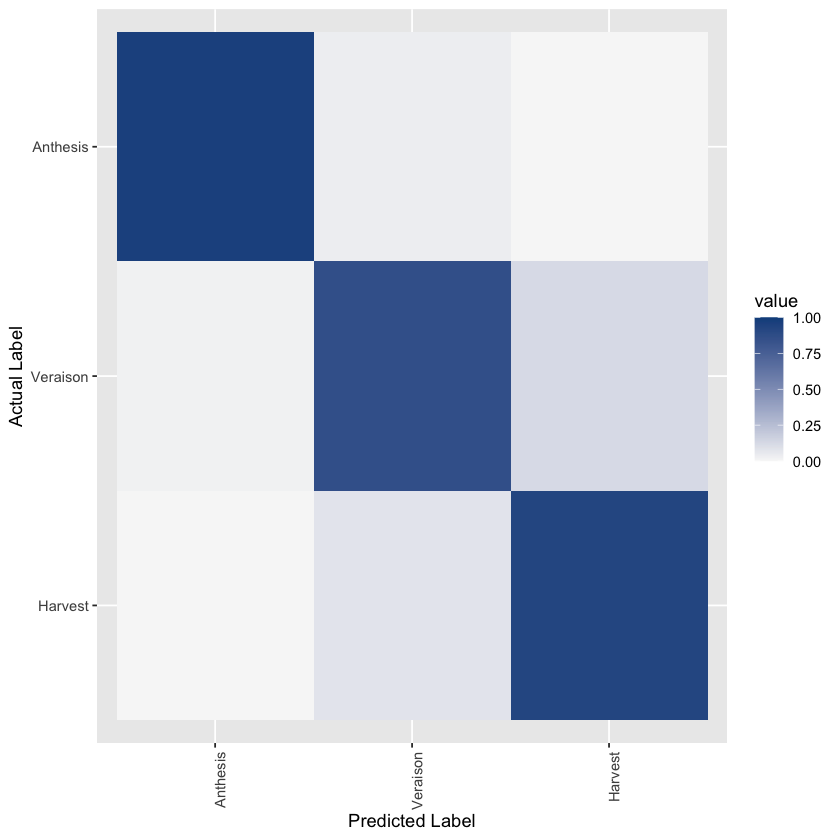

In [48]:
d <- pGeneExpressionrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_geneExpression_phenologyImportFeatures.csv', quote=F)
idx <- head(order(important_features$MeanDecreaseAccuracy, decreasing=T), 10)
important_features[idx,]

d <- pGeneExpressionrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(Anthesis:Harvest)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Anthesis', 'Veraison', 'Harvest'))

d <- d %>% gather(x, value, Anthesis:Harvest)
d$x <- factor(d$x, levels=c('Anthesis', 'Veraison', 'Harvest'))



p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Anthesis', 'Veraison', 'Harvest')) + 
     scale_y_discrete(labels=c('Harvest', 'Veraison', 'Anthesis'))

p

pdf('2017_geneExpression_RFconfmat_phenology.pdf')
  p
dev.off()

Random Forest 

170 samples
100 predictors
  3 classes: 'Anthesis', 'Veraison', 'Harvest' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 170, 170, 170, 170, 170, 170, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  15    0.9283353  0.8918413
  23    0.9222592  0.8826197
  24    0.9203781  0.8798656
  27    0.9212451  0.8811830
  30    0.9182438  0.8766491
  34    0.9203065  0.8797222
  36    0.9201880  0.8794685
  39    0.9140564  0.8702879
  41    0.9145473  0.8711153
  48    0.9155196  0.8725336
  57    0.9091269  0.8628876
  60    0.9113478  0.8661635
  66    0.9121038  0.8674174
  67    0.9100507  0.8643075
  72    0.9142195  0.8704438
  88    0.9122367  0.8674144
  91    0.9114497  0.8662677
  94    0.9114674  0.8662957
  95    0.9136537  0.8695378
  98    0.9084808  0.8618512

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 15.

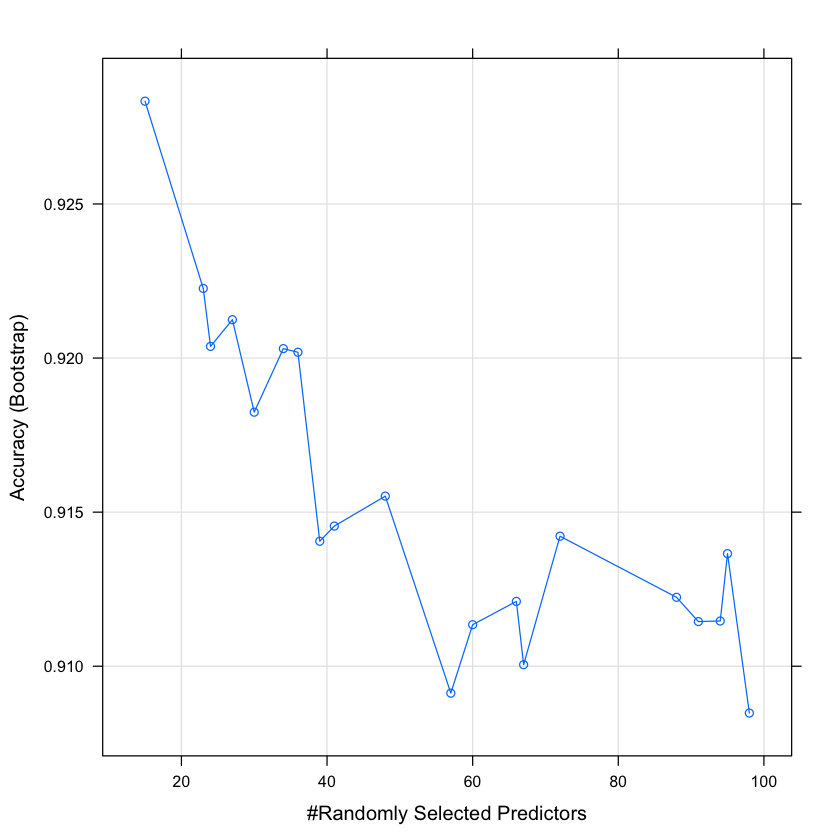

In [49]:
pGeneExpressionrf
plot(pGeneExpressionrf)

In [50]:
y_pred <- predict(pGeneExpressionrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction Anthesis Veraison Harvest
  Anthesis       11        0       0
  Veraison        0       12       2
  Harvest         0        1      16

Overall Statistics
                                         
               Accuracy : 0.9286         
                 95% CI : (0.8052, 0.985)
    No Information Rate : 0.4286         
    P-Value [Acc > NIR] : 1.01e-11       
                                         
                  Kappa : 0.8909         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Anthesis Class: Veraison Class: Harvest
Sensitivity                   1.0000          0.9231         0.8889
Specificity                   1.0000          0.9310         0.9583
Pos Pred Value                1.0000          0.8571         0.9412
Neg Pred Value                1.0000          0.9643         0.9200
Prevalence                    0.2619  

#### Rootstock

In [26]:
# get train test labels
rs.labels <- treatments$Rootstock
y_train <- rs.labels[train_idx]
y_test <- rs.labels[test_idx]

rsGeneExpressionGrid <- expand.grid(mtry=sample(x=2:100, size=20, replace=F))
rsGeneExpressionrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rsGeneExpressionGrid, ntree=100, keep.forest=T, importance=1)

X3309C    SO4       y         x         value    
1 0.2325581 0.1395349 Ungrafted X1103P    0.3023256
2 0.1521739 0.2608696 1103P     X1103P    0.3913043
3 0.2000000 0.3750000 3309C     X1103P    0.1750000
4 0.2926829 0.1951220 SO4       X1103P    0.2926829
5 0.2325581 0.1395349 Ungrafted Ungrafted 0.3255814
6 0.1521739 0.2608696 1103P     Ungrafted 0.1956522
7 0.2000000 0.3750000 3309C     Ungrafted 0.2500000
8 0.2926829 0.1951220 SO4       Ungrafted 0.2195122

Ungrafted    X1103P       X3309C        SO4           MeanDecreaseAccuracy
PC97  0.003411417 0.0024942135  0.0026091270  0.0030534137 0.002724027         
PC98  0.005542600 0.0014593059 -0.0016789322  0.0045789027 0.002675950         
PC96  0.001655840 0.0010753355  0.0031998747  0.0049102358 0.002544305         
PC12  0.002524345 0.0005800547 -0.0010484736  0.0058731326 0.002261361         
PC78  0.002323906 0.0023253968  0.0008585165  0.0026972831 0.002201664         
PC44  0.005305350 0.0007757959  0.0028916900  0.0002508693 0.002190741         
PC27 -0.001396316 0.0026228037  0.0054564602  0.0030376609 0.002170033         
PC62  0.005248377 0.0008277204  0.0003279857  0.0009850607 0.002133649         
PC63  0.003225251 0.0045221546  0.0043625223 -0.0020861966 0.002012285         
PC55  0.000926704 0.0003402301  0.0003950853  0.0054092974 0.001668953         
     MeanDecreaseGini
PC97 0.9257992       
PC98 1.8111442       
PC96 2.0123487       
PC12 1.7686104       
PC78 1.1355043       
PC44 2.2932748       
PC27 1.3432882       
PC62 1.1774134       
PC63 1.4213335       
PC55 1.4279107

pdf 
  2

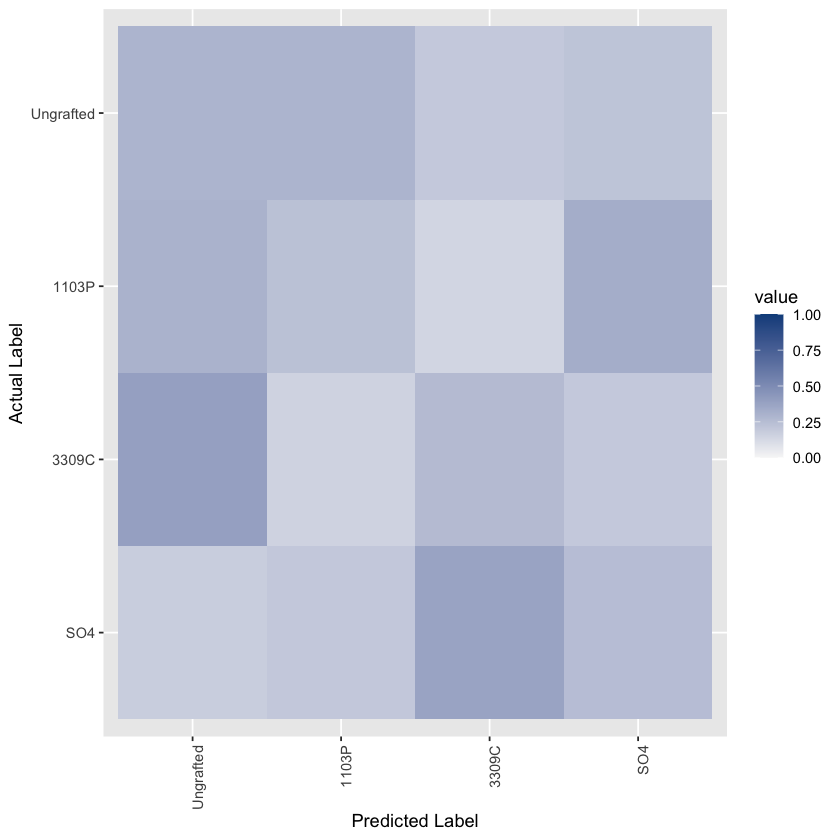

In [30]:
d <- rsGeneExpressionrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_geneExpression_rootstockImportFeatures.csv', quote=F)
idx <- head(order(important_features$MeanDecreaseAccuracy, decreasing=T), 10)
important_features[idx,]

d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('1103P', '3309C', 'SO4', 'Ungrafted'))

d <- d %>% gather(x, value, Ungrafted:SO4)
d$x <- factor(d$x, levels=c('X1103P', 'X3309C', 'SO4', 'Ungrafted'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') +  
     scale_x_discrete(labels=c('Ungrafted', '1103P', '3309C', 'SO4')) + 
     scale_y_discrete(labels=rev(c('Ungrafted', '1103P', '3309C', 'SO4')))
p 

pdf('2017_geneExpression_RFconfmat_rootstock.pdf')
  p
dev.off()

Random Forest 

170 samples
100 predictors
  4 classes: 'Ungrafted', '1103P', '3309C', 'SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 170, 170, 170, 170, 170, 170, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa      
   3    0.2627551  0.040251529
   4    0.2595459  0.035195835
   8    0.2733567  0.052265919
   9    0.2638069  0.040789915
  29    0.2420399  0.010642483
  34    0.2536113  0.023539811
  35    0.2593374  0.032269906
  43    0.2530089  0.022063165
  50    0.2596095  0.031368546
  52    0.2500918  0.016616931
  59    0.2473407  0.015110959
  60    0.2439012  0.009834506
  67    0.2571179  0.026411281
  68    0.2593740  0.029860379
  69    0.2606209  0.032943255
  71    0.2638092  0.033911488
  74    0.2489855  0.014866386
  80    0.2563056  0.026644025
  88    0.2538116  0.022370506
  89    0.2587860  0.029771349

Accuracy was used to select the optimal model using the largest value.
The final value used f

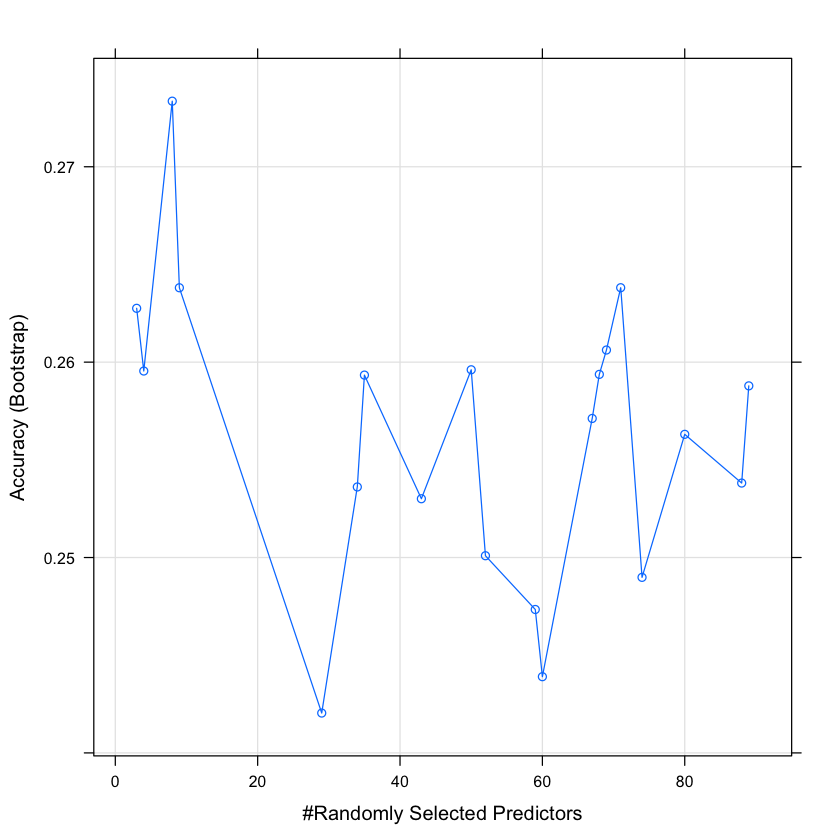

In [31]:
rsGeneExpressionrf
plot(rsGeneExpressionrf)

In [32]:
y_pred <- predict(rsGeneExpressionrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted         2     1     4   5
  1103P             2     3     3   2
  3309C             2     2     3   1
  SO4               4     2     4   2

Overall Statistics
                                          
               Accuracy : 0.2381          
                 95% CI : (0.1205, 0.3945)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 0.9333          
                                          
                  Kappa : -0.009          
                                          
 Mcnemar's Test P-Value : 0.7948          

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                   0.20000      0.37500      0.21429    0.20000
Specificity                   0.68750      0.79412      0.82143    0.68750
Pos Pred Value                0.16667      0.30000      0.37500    0.16667
Neg Pred Value            

#### Row

In [33]:
# get train test labels
rs.labels <- treatments$Row
y_train <- rs.labels[train_idx]
y_test <- rs.labels[test_idx]

rowGeneExpressionGrid <- expand.grid(mtry=sample(x=2:100, size=20, replace=F))
rowGeneExpressionrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rowGeneExpressionGrid, ntree=100, keep.forest=T, importance=1)

X8          X9            X10          X11           X12          
PC4  0.145627706  0.0549260462  0.022484127  0.0483134921  0.0474375902
PC6  0.153295455  0.0493524531  0.001801587  0.0352378455  0.0040606061
PC17 0.020960678  0.0012222222  0.023397186  0.0160317460  0.0200079365
PC12 0.016071429 -0.0001785714 -0.001873016 -0.0006071429  0.0143650794
PC10 0.002714646  0.0113611111  0.008452381  0.0106666667  0.0040952381
PC25 0.007555556  0.0034722222  0.014317460 -0.0005952381  0.0003055556
PC34 0.007361111  0.0075000000  0.001250000  0.0022222222  0.0109090909
PC19 0.002861111  0.0027741703  0.004400794 -0.0005555556 -0.0004563492
PC13 0.002361111  0.0033730159  0.001250000 -0.0009563492  0.0014361472
PC27 0.002301227  0.0012500000  0.000000000  0.0083247863 -0.0000952381
     X13          X14           X15         X16           MeanDecreaseAccuracy
PC4   0.036634921  0.0580955988 0.024947691  0.0649051227 0.054178263         
PC6   0.025305556  0.0232827173 0.023587302  0.0653214286 0.042122029         
PC17  0.005690476  0.0129018759 0.010916667 -0.0018214286 0.011874353         
PC12  0.038817460 -0.0019404762 0.003472222  0.0195238095 0.008612917         
PC10  0.001904762 -0.0043452381 0.002111111  0.0010674603 0.003935199         
PC25 -0.001111111 -0.0041071429 0.006011905 -0.0002380952 0.003032919         
PC34  0.000000000 -0.0010000000 0.001428571 -0.0008095238 0.002569149         
PC19  0.005000000 -0.0030714286 0.003337662 -0.0001388889 0.002307420         
PC13  0.009678571  0.0005714286 0.001666667  0.0011111111 0.001968829         
PC27 -0.001111111 -0.0025000000 0.003222222  0.0024007937 0.001723276         
     MeanDecreaseGini
PC4  11.922519       
PC6  10.694383       
PC17  5.081885       
PC12  3.788371       
PC10  2.006216       
PC25  1.941316       
PC34  1.178241       
PC19  2.786613       
PC13  1.754968       
PC27  1.695235

pdf 
  2

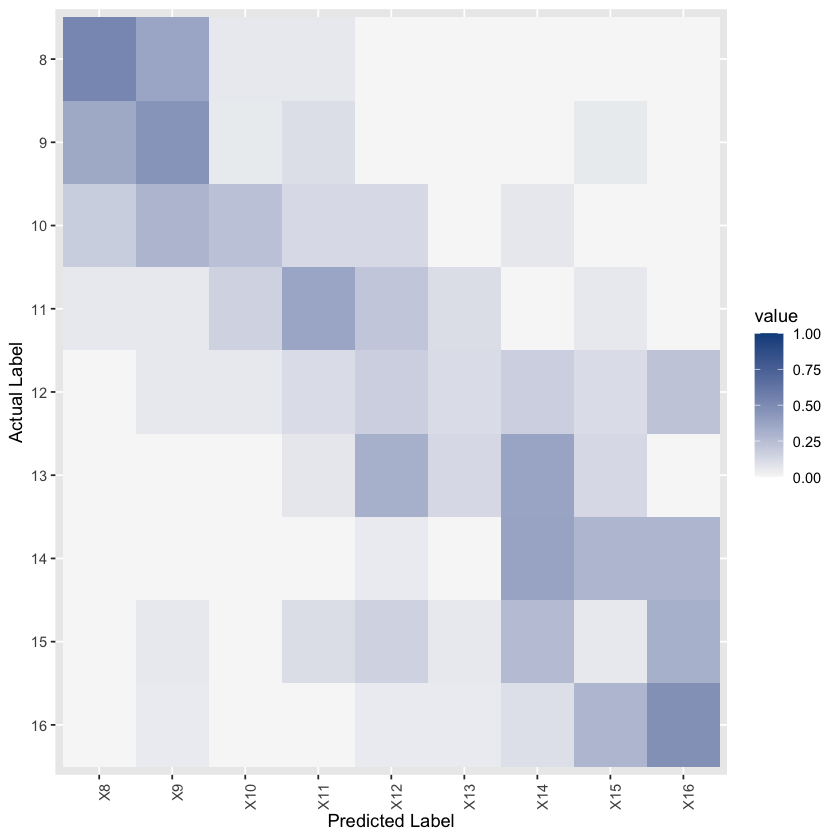

In [42]:
d <- rowGeneExpressionrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_geneExpression_rowImportFeatures.csv', quote=F)
idx <- head(order(important_features$MeanDecreaseAccuracy, decreasing=T), 10)
important_features[idx,]

d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('8', '9', '10', '11', '12', '13', '14', '15', '16'))

d <- d %>% gather(x, value, X8:X16)
d$x <- factor(d$x, levels=c('X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_y_discrete(labels=rev(c('8', '9', '10', '11', '12', '13', '14', '15', '16')))
p 

pdf('2017_geneExpression_RFconfmat_row.pdf')
  p
dev.off()

Random Forest 

170 samples
100 predictors
  9 classes: '8', '9', '10', '11', '12', '13', '14', '15', '16' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 170, 170, 170, 170, 170, 170, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   3    0.2253006  0.1412035
   7    0.2486260  0.1652800
  11    0.2679449  0.1864388
  13    0.2576709  0.1749535
  19    0.2652618  0.1822256
  21    0.2584134  0.1745916
  23    0.2595941  0.1760146
  26    0.2574151  0.1736404
  27    0.2685226  0.1857105
  32    0.2570342  0.1724448
  35    0.2655378  0.1821619
  42    0.2713071  0.1883722
  44    0.2604142  0.1772403
  46    0.2590044  0.1748022
  73    0.2458353  0.1596325
  74    0.2491354  0.1631526
  75    0.2429769  0.1565973
  86    0.2507440  0.1649006
  91    0.2358477  0.1489769
  92    0.2412798  0.1544261

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 42.

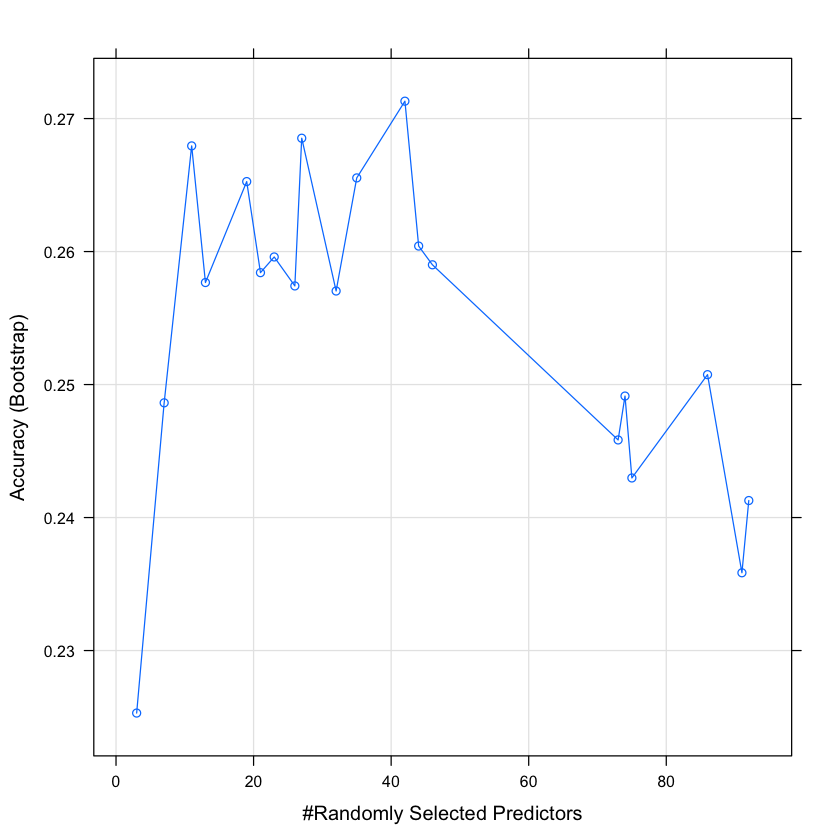

In [43]:
rowGeneExpressionrf
plot(rowGeneExpressionrf)

In [44]:
y_pred <- predict(rowGeneExpressionrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction 8 9 10 11 12 13 14 15 16
        8  4 2  0  0  0  0  0  0  0
        9  0 1  1  0  0  0  0  0  0
        10 0 1  1  2  0  0  0  0  0
        11 1 0  1  2  1  0  0  0  0
        12 0 0  0  0  3  3  0  2  0
        13 0 0  0  0  1  2  1  0  0
        14 0 0  1  0  1  2  2  2  0
        15 0 0  0  0  0  0  0  0  1
        16 0 0  0  0  0  1  0  1  2

Overall Statistics
                                          
               Accuracy : 0.4048          
                 95% CI : (0.2563, 0.5672)
    No Information Rate : 0.1905          
    P-Value [Acc > NIR] : 0.001079        
                                          
                  Kappa : 0.3308          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 8 Class: 9 Class: 10 Class: 11 Class: 12 Class: 13
Sensitivity           0.80000  0.25000   0.25000   0.50000   0.50000   0.25000

In [47]:
rowGeneExpressionrf$finalModel


Call:
 randomForest(x = x, y = y, ntree = 100, mtry = param$mtry, importance = 1,      keep.forest = ..2) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 42

        OOB estimate of  error rate: 68.24%
Confusion matrix:
    8 9 10 11 12 13 14 15 16 class.error
8  10 7  1  1  0  0  0  0  0   0.4736842
9   7 9  1  2  0  0  0  1  0   0.5500000
10  3 5  4  2  2  0  1  0  0   0.7647059
11  1 1  3  7  4  2  0  1  0   0.6315789
12  0 1  1  2  3  2  3  2  4   0.8333333
13  0 0  0  1  5  2  6  2  0   0.8750000
14  0 0  0  0  1  0  8  6  6   0.6190476
15  0 1  0  2  3  1  5  1  6   0.9473684
16  0 1  0  0  1  1  2  6 10   0.5238095

# Traditional Gene Expression Analysis Contrasts

For reasons that mostly have to do with me being ineffecient, this analysis was computed over several computing sessions over two computers. The first section that is entirely commented was done on a university cluster while the PC work was computed on a local laptop during Covid-19 shelter-in-place orders. This section will be computed back on the cluster because my laptop won't install DESeq2, but I will use the originally fitted dds object to call the contrasts of interest. As of now, this section is presented first in the manuscript. This work has additionally been carried out in an expanded fashion by coauthors Qin Ma and Cankun Wang. 

In [ ]:
load('./2017_model_refit_elegantInteractions_leafOnly.Rdata')

In [4]:
idx <- rowSums( counts(dds, normalized=TRUE) >= 2 ) >= 5
genes <- rownames(dds)[idx]
length(genes)

idx <- idx[-which(genes == 'Vitvi19g01871')]
genes <- genes[-which(genes == 'Vitvi19g01871')]

dds_filt <- dds[idx,]
dds_filt <- DESeq(dds_filt)

[1] 23460

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Block

In [34]:
format_summary <- function(res, c1, c2){
    r <- dim(res)[1]
    lt_n1.5 <- sum(res[['log2FoldChange']] < -1.5)
    lt_n1.0 <- sum(res[['log2FoldChange']] < -1)
    gt_1.0 <- sum(res[['log2FoldChange']] > 1)
    gt_1.5 <- sum(res[['log2FoldChange']] > 1.5)
    print(sprintf("%s genes are differentially expressed in the comparison of %s and %s.", r, c1, c2))
    print(sprintf("---%s have LFC < -1.5", lt_n1.5))
    print(sprintf("---%s have LFC < -1.0", lt_n1.0))
    print(sprintf("---%s have LFC > 1.0", gt_1.5))
    print(sprintf("---%s have LFC > 1.5", gt_1.5))
}

In [ ]:
b_A.B <- subset(results(dds_filt, contrast=c('Block', 'A', 'B')), padj < 0.05/3)
b_A.C <- subset(results(dds_filt, contrast=c('Block', 'A', 'C')), padj < 0.05/3)
b_B.C <- subset(results(dds_filt, contrast=c('Block', 'B', 'C')), padj < 0.05/3)

In [35]:
format_summary(b_A.B, "A", "B")
format_summary(b_A.C, "A", "C")
format_summary(b_B.C, "B", "C")

[1] "3195 genes are differentially expressed in the comparison of A and B."
[1] "---8 have LFC < -1.5"
[1] "---67 have LFC < -1.0"
[1] "---5 have LFC > 1.0"
[1] "---5 have LFC > 1.5"
[1] "6931 genes are differentially expressed in the comparison of A and C."
[1] "---72 have LFC < -1.5"
[1] "---352 have LFC < -1.0"
[1] "---75 have LFC > 1.0"
[1] "---75 have LFC > 1.5"
[1] "3027 genes are differentially expressed in the comparison of B and C."
[1] "---6 have LFC < -1.5"
[1] "---61 have LFC < -1.0"
[1] "---10 have LFC > 1.0"
[1] "---10 have LFC > 1.5"


### Irrigation

In [27]:
Irr_None.RDI <- subset(results(dds_filt, contrast=c('Irrigation', 'None', 'RDI')), padj < 0.05/3)
Irr_None.Full <- subset(results(dds_filt, contrast=c('Irrigation', 'None', 'Full')), padj < 0.05/3)
Irr_RDI.Full <- subset(results(dds_filt, contrast=c('Irrigation', 'RDI', 'Full')), padj < 0.05/3)

In [36]:
format_summary(Irr_None.RDI, "None", "RDI")
format_summary(Irr_None.Full, "None", "Full")
format_summary(Irr_RDI.Full, "RDI", "Full")

[1] "3 genes are differentially expressed in the comparison of None and RDI."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "108 genes are differentially expressed in the comparison of None and Full."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---2 have LFC > 1.0"
[1] "---2 have LFC > 1.5"
[1] "21 genes are differentially expressed in the comparison of RDI and Full."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"


### Rootstock (by Phenology)

#### Anthesis

In [ ]:
a_ungrafted.1103P <- subset(results(dds_filt, contrast=c('group', 'Anthesis_Ungrafted', 'Anthesis_1103P')), padj < 0.05/6)
a_ungrafted.3309C <- subset(results(dds_filt, contrast=c('group', 'Anthesis_Ungrafted', 'Anthesis_3309C')), padj < 0.05/6)
a_ungrafted.SO4   <- subset(results(dds_filt, contrast=c('group', 'Anthesis_Ungrafted', 'Anthesis_SO4')), padj < 0.05/6)
a_1103P.3309C <- subset(results(dds_filt, contrast=c('group', 'Anthesis_1103P', 'Anthesis_3309C')), padj < 0.05/6)
a_1103P.SO4 <- subset(results(dds_filt, contrast=c('group', 'Anthesis_1103P', 'Anthesis_SO4')), padj < 0.05/6)
a_3309C.SO4 <- subset(results(dds_filt, contrast=c('group', 'Anthesis_3309C', 'Anthesis_SO4')), padj < 0.05/6)

In [39]:
format_summary(a_ungrafted.1103P, 'Ungrafted', '1103P')
format_summary(a_ungrafted.3309C, 'Ungrafted', '3309C')
format_summary(a_ungrafted.SO4, 'Ungrafted', 'SO4')
format_summary(a_1103P.3309C, '1103P', '3309C')
format_summary(a_1103P.SO4, '1103P', 'SO4')
format_summary(a_3309C.SO4, '3309C', 'SO4')

[1] "3 genes are differentially expressed in the comparison of Ungrafted and 1103P."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---3 have LFC > 1.0"
[1] "---3 have LFC > 1.5"
[1] "1 genes are differentially expressed in the comparison of Ungrafted and 3309C."
[1] "---1 have LFC < -1.5"
[1] "---1 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "1 genes are differentially expressed in the comparison of Ungrafted and SO4."
[1] "---1 have LFC < -1.5"
[1] "---1 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "4 genes are differentially expressed in the comparison of 1103P and 3309C."
[1] "---4 have LFC < -1.5"
[1] "---4 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "4 genes are differentially expressed in the comparison of 1103P and SO4."
[1] "---4 have LFC < -1.5"
[1] "---4 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "0 genes are differentially expressed in the comparis

In [ ]:
v_ungrafted.1103P <- subset(results(dds_filt, contrast=c('group', 'Veraison_Ungrafted', 'Veraison_1103P')), padj < 0.05/6)
v_ungrafted.3309C <- subset(results(dds_filt, contrast=c('group', 'Veraison_Ungrafted', 'Veraison_3309C')), padj < 0.05/6)
v_ungrafted.SO4   <- subset(results(dds_filt, contrast=c('group', 'Veraison_Ungrafted', 'Veraison_SO4')), padj < 0.05/6)
v_1103P.3309C <- subset(results(dds_filt, contrast=c('group', 'Veraison_1103P', 'Veraison_3309C')), padj < 0.05/6)
v_1103P.SO4 <- subset(results(dds_filt, contrast=c('group', 'Veraison_1103P', 'Veraison_SO4')), padj < 0.05/6)
v_3309C.SO4 <- subset(results(dds_filt, contrast=c('group', 'Veraison_3309C', 'Veraison_SO4')), padj < 0.05/6)

In [41]:
format_summary(v_ungrafted.1103P, 'Ungrafted', '1103P')
format_summary(v_ungrafted.3309C, 'Ungrafted', '3309C')
format_summary(v_ungrafted.SO4, 'Ungrafted', 'SO4')
format_summary(v_1103P.3309C, '1103P', '3309C')
format_summary(v_1103P.SO4, '1103P', 'SO4')
format_summary(v_3309C.SO4, '3309C', 'SO4')

[1] "406 genes are differentially expressed in the comparison of Ungrafted and 1103P."
[1] "---313 have LFC < -1.5"
[1] "---379 have LFC < -1.0"
[1] "---1 have LFC > 1.0"
[1] "---1 have LFC > 1.5"
[1] "1 genes are differentially expressed in the comparison of Ungrafted and 3309C."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "0 genes are differentially expressed in the comparison of Ungrafted and SO4."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "29 genes are differentially expressed in the comparison of 1103P and 3309C."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---24 have LFC > 1.0"
[1] "---24 have LFC > 1.5"
[1] "197 genes are differentially expressed in the comparison of 1103P and SO4."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---162 have LFC > 1.0"
[1] "---162 have LFC > 1.5"
[1] "0 genes are differentially expressed 

In [ ]:
h_ungrafted.1103P <- subset(results(dds_filt, contrast=c('group', 'Harvest_Ungrafted', 'Harvest_1103P')), padj < 0.05/6)
h_ungrafted.3309C <- subset(results(dds_filt, contrast=c('group', 'Harvest_Ungrafted', 'Harvest_3309C')), padj < 0.05/6)
h_ungrafted.SO4   <- subset(results(dds_filt, contrast=c('group', 'Harvest_Ungrafted', 'Harvest_SO4')), padj < 0.05/6)
h_1103P.3309C <- subset(results(dds_filt, contrast=c('group', 'Harvest_1103P', 'Harvest_3309C')), padj < 0.05/6)
h_1103P.SO4 <- subset(results(dds_filt, contrast=c('group', 'Harvest_1103P', 'Harvest_SO4')), padj < 0.05/6)
h_3309C.SO4 <- subset(results(dds_filt, contrast=c('group', 'Harvest_3309C', 'Harvest_SO4')), padj < 0.05/6)

In [42]:
format_summary(h_ungrafted.1103P, 'Ungrafted', '1103P')
format_summary(h_ungrafted.3309C, 'Ungrafted', '3309C')
format_summary(h_ungrafted.SO4, 'Ungrafted', 'SO4')
format_summary(h_1103P.3309C, '1103P', '3309C')
format_summary(h_1103P.SO4, '1103P', 'SO4')
format_summary(h_3309C.SO4, '3309C', 'SO4')

[1] "0 genes are differentially expressed in the comparison of Ungrafted and 1103P."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "2 genes are differentially expressed in the comparison of Ungrafted and 3309C."
[1] "---2 have LFC < -1.5"
[1] "---2 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "0 genes are differentially expressed in the comparison of Ungrafted and SO4."
[1] "---0 have LFC < -1.5"
[1] "---0 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "13 genes are differentially expressed in the comparison of 1103P and 3309C."
[1] "---10 have LFC < -1.5"
[1] "---13 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "2 genes are differentially expressed in the comparison of 1103P and SO4."
[1] "---2 have LFC < -1.5"
[1] "---2 have LFC < -1.0"
[1] "---0 have LFC > 1.0"
[1] "---0 have LFC > 1.5"
[1] "0 genes are differentially expressed in the compa

### Phenology (by Rootstock)

I forgot to change the Pvalue correction for this section, so there are likely a few additional genes responding here. However, this will be the scope of future analysis. 

#### Ungrafted

In [ ]:
ungrafted_anthesis.veraison <- subset(results(dds_filt, contrast=c('group', 'Anthesis_Ungrafted', 'Veraison_Ungrafted')), padj < 0.05/6)
ungrafted_anthesis.harvest <- subset(results(dds_filt, contrast=c('group', 'Anthesis_Ungrafted', 'Harvest_Ungrafted')), padj < 0.05/6)
ungrafted_veraison.harvest <- subset(results(dds_filt, contrast=c('group', 'Veraison_Ungrafted', 'Harvest_Ungrafted')), padj < 0.05/6)

In [43]:
format_summary(ungrafted_anthesis.veraison, 'Anthesis', 'Veraison')
format_summary(ungrafted_anthesis.harvest, 'Anthesis', 'Harvest')
format_summary(ungrafted_veraison.harvest, 'Veraison', 'Harvest')

[1] "6567 genes are differentially expressed in the comparison of Anthesis and Veraison."
[1] "---1094 have LFC < -1.5"
[1] "---1912 have LFC < -1.0"
[1] "---643 have LFC > 1.0"
[1] "---643 have LFC > 1.5"
[1] "11551 genes are differentially expressed in the comparison of Anthesis and Harvest."
[1] "---2336 have LFC < -1.5"
[1] "---3462 have LFC < -1.0"
[1] "---2929 have LFC > 1.0"
[1] "---2929 have LFC > 1.5"
[1] "7407 genes are differentially expressed in the comparison of Veraison and Harvest."
[1] "---703 have LFC < -1.5"
[1] "---1286 have LFC < -1.0"
[1] "---1923 have LFC > 1.0"
[1] "---1923 have LFC > 1.5"


#### 1103P

In [ ]:
x1103P_anthesis.veraison <- subset(results(dds_filt, contrast=c('group', 'Anthesis_1103P', 'Veraison_1103P')), padj < 0.05/6)
x1103P_anthesis.harvest <- subset(results(dds_filt, contrast=c('group', 'Anthesis_1103P', 'Harvest_1103P')), padj < 0.05/6)
x1103P_veraison.harvest <- subset(results(dds_filt, contrast=c('group', 'Veraison_1103P', 'Harvest_1103P')), padj < 0.05/6)

In [44]:
format_summary(x1103P_anthesis.veraison, 'Anthesis', 'Veraison')
format_summary(x1103P_anthesis.harvest, 'Anthesis', 'Harvest')
format_summary(x1103P_veraison.harvest, 'Veraison', 'Harvest')

[1] "8911 genes are differentially expressed in the comparison of Anthesis and Veraison."
[1] "---1863 have LFC < -1.5"
[1] "---2902 have LFC < -1.0"
[1] "---1028 have LFC > 1.0"
[1] "---1028 have LFC > 1.5"
[1] "12120 genes are differentially expressed in the comparison of Anthesis and Harvest."
[1] "---2408 have LFC < -1.5"
[1] "---3571 have LFC < -1.0"
[1] "---3284 have LFC > 1.0"
[1] "---3284 have LFC > 1.5"
[1] "6691 genes are differentially expressed in the comparison of Veraison and Harvest."
[1] "---346 have LFC < -1.5"
[1] "---737 have LFC < -1.0"
[1] "---2108 have LFC > 1.0"
[1] "---2108 have LFC > 1.5"


#### 3309C

In [ ]:
x3309C_anthesis.veraison <- subset(results(dds_filt, contrast=c('group', 'Anthesis_3309C', 'Veraison_3309C')), padj < 0.05/6)
x3309C_anthesis.harvest <- subset(results(dds_filt, contrast=c('group', 'Anthesis_3309C', 'Harvest_3309C')), padj < 0.05/6)
x3309C_veraison.harvest <- subset(results(dds_filt, contrast=c('group', 'Veraison_3309C', 'Harvest_3309C')), padj < 0.05/6)

In [45]:
format_summary(x3309C_anthesis.veraison, 'Anthesis', 'Veraison')
format_summary(x3309C_anthesis.harvest, 'Anthesis', 'Harvest')
format_summary(x3309C_veraison.harvest, 'Veraison', 'Harvest')

[1] "6912 genes are differentially expressed in the comparison of Anthesis and Veraison."
[1] "---1259 have LFC < -1.5"
[1] "---2049 have LFC < -1.0"
[1] "---546 have LFC > 1.0"
[1] "---546 have LFC > 1.5"
[1] "11817 genes are differentially expressed in the comparison of Anthesis and Harvest."
[1] "---2586 have LFC < -1.5"
[1] "---3743 have LFC < -1.0"
[1] "---2904 have LFC > 1.0"
[1] "---2904 have LFC > 1.5"
[1] "7935 genes are differentially expressed in the comparison of Veraison and Harvest."
[1] "---857 have LFC < -1.5"
[1] "---1577 have LFC < -1.0"
[1] "---1967 have LFC > 1.0"
[1] "---1967 have LFC > 1.5"


#### SO4

In [ ]:
xSO4_anthesis.veraison <- subset(results(dds_filt, contrast=c('group', 'Anthesis_SO4', 'Veraison_SO4')), padj < 0.05/6)
xSO4_anthesis.harvest <- subset(results(dds_filt, contrast=c('group', 'Anthesis_SO4', 'Harvest_SO4')), padj < 0.05/6)
xSO4_veraison.harvest <- subset(results(dds_filt, contrast=c('group', 'Veraison_SO4', 'Harvest_SO4')), padj < 0.05/6)

In [46]:
format_summary(xSO4_anthesis.veraison, 'Anthesis', 'Veraison')
format_summary(xSO4_anthesis.harvest, 'Anthesis', 'Harvest')
format_summary(xSO4_veraison.harvest, 'Veraison', 'Harvest')

[1] "5878 genes are differentially expressed in the comparison of Anthesis and Veraison."
[1] "---960 have LFC < -1.5"
[1] "---1675 have LFC < -1.0"
[1] "---560 have LFC > 1.0"
[1] "---560 have LFC > 1.5"
[1] "11629 genes are differentially expressed in the comparison of Anthesis and Harvest."
[1] "---2395 have LFC < -1.5"
[1] "---3560 have LFC < -1.0"
[1] "---2938 have LFC > 1.0"
[1] "---2938 have LFC > 1.5"
[1] "7792 genes are differentially expressed in the comparison of Veraison and Harvest."
[1] "---828 have LFC < -1.5"
[1] "---1534 have LFC < -1.0"
[1] "---1972 have LFC > 1.0"
[1] "---1972 have LFC > 1.5"


In [76]:
ungrafted_anthesis.veraison <- as.data.frame(ungrafted_anthesis.veraison)
ungrafted_anthesis.harvest <- as.data.frame(ungrafted_anthesis.harvest)
ungrafted_veraison.harvest <- as.data.frame(ungrafted_veraison.harvest)

x1103P_anthesis.veraison <- as.data.frame(x1103P_anthesis.veraison)
x1103P_anthesis.harvest <- as.data.frame(x1103P_anthesis.harvest)
x1103P_veraison.harvest <- as.data.frame(x1103P_veraison.harvest)

x3309C_anthesis.veraison <- as.data.frame(x3309C_anthesis.veraison)
x3309C_anthesis.harvest <- as.data.frame(x3309C_anthesis.harvest)
x3309C_veraison.harvest <- as.data.frame(x3309C_veraison.harvest)

xSO4_anthesis.veraison <- as.data.frame(xSO4_anthesis.veraison)
xSO4_anthesis.harvest <- as.data.frame(xSO4_anthesis.harvest)
xSO4_veraison.harvest <- as.data.frame(xSO4_veraison.harvest)

##### Bin Genes Based on General Response

In [108]:
a_v <- rownames(ungrafted_anthesis.veraison)[which(rownames(ungrafted_anthesis.veraison) %in% rownames(x1103P_anthesis.veraison))]
a_v <- a_v[which(a_v %in% rownames(x3309C_anthesis.veraison))]
a_v <- a_v[which(a_v %in% rownames(xSO4_anthesis.veraison))]
length(a_v)

a_h <- rownames(ungrafted_anthesis.harvest)[which(rownames(ungrafted_anthesis.harvest) %in% rownames(x1103P_anthesis.harvest))]
a_h <- a_h[which(a_h %in% rownames(x3309C_anthesis.harvest))]
a_h <- a_h[which(a_h %in% rownames(xSO4_anthesis.harvest))]
length(a_h)

v_h <- rownames(ungrafted_veraison.harvest)[which(rownames(ungrafted_veraison.harvest)%in% rownames(x1103P_veraison.harvest))]
v_h <- v_h[which(v_h %in% rownames(x3309C_veraison.harvest))]
v_h <- v_h[which(v_h %in% rownames(xSO4_veraison.harvest))]
length(v_h)

[1] 4354

[1] 9644

[1] 4679

In [125]:
'%!in%' <- Negate('%in%')

dirChange <- function(v){
    # for reasons, if the lfc is negative that is an upregulation over time
    # so sign is opposite of expected
    if (v > 0){
        return (-1)
    } else {
        return (1)
    }
}

isUpDown <- function(listGenes, d1, d2, d3, d4){
    up <- c()
    down <- c()
    for (gene in listGenes){
        change <- 0
        d1.val <- d1[gene,]$log2FoldChange
        d2.val <- d2[gene,]$log2FoldChange
        d3.val <- d3[gene,]$log2FoldChange
        d4.val <- d4[gene,]$log2FoldChange        
        change <- change + dirChange(d1.val) + dirChange(d2.val) + dirChange(d3.val) + dirChange(d3.val)
        if (change == 4){
            up <- c(up, gene)
        } else if (change == -4){
            down <- c(down, gene)
        } else {
            print(sprintf("%s is inconsistent across rootstocks", gene))
        }
    }
    return (list(up=up, down=down))
}

a_v.lc <- isUpDown(a_v, ungrafted_anthesis.veraison, x1103P_anthesis.veraison, x3309C_anthesis.veraison, xSO4_anthesis.veraison)
a_h.lc <- isUpDown(a_h, ungrafted_anthesis.harvest, x1103P_anthesis.harvest, x3309C_anthesis.harvest, xSO4_anthesis.harvest)
v_h.lc <- isUpDown(v_h, ungrafted_veraison.harvest, x1103P_veraison.harvest, x3309C_veraison.harvest, xSO4_veraison.harvest)


In [126]:
length(a_v.lc[['up']])
length(a_v.lc[['down']])

length(a_h.lc[['up']])
length(a_h.lc[['down']])

length(v_h.lc[['up']])
length(v_h.lc[['down']])

[1] 2325

[1] 2029

[1] 4424

[1] 5220

[1] 1482

[1] 3197

In [129]:
# make list of all genes
genes <- unique(c(a_v, a_h, v_h))
length(genes)

[1] 10530

In [159]:
# loop over all genes and bin in loop with nested if/else #efficient (jk)
# see fig for details #lol also make figure

bins <- list(UU=c(), DD=c(), UD=c(), DU=c(),
             U_=c(), ._U=c(), D_=c(), ._D=c(),
             ..U=c(), ..D=c())

for (gene in genes){
    # if anthesis -> veraison is upregulated
    if (gene %in% a_v.lc[['up']]){
        if (gene %in% v_h.lc[['up']]){
           bins[['UU']] <- c(bins[['UU']], gene)
        } else if (gene %in% v_h.lc[['down']]){
            bins[['UD']] <- c(bins[['UD']], gene)
        } else {
            bins[['U_']] <- c(bins[['U_']], gene)
        }
        
    # if anthesis -> veraison is downregulated}
    } else if (gene %in% a_v.lc[['down']]){
        if (gene %in% v_h.lc[['up']]){
           bins[['DU']] <- c(bins[['DU']], gene)
        } else if (gene %in% v_h.lc[['down']]){
            bins[['DD']] <- c(bins[['DD']], gene)
        } else {
            bins[['D_']] <- c(bins[['D_']], gene)
        }
        
    # if anthesis -> veraison is not differentially regulated
    } else {
        if (gene %in% v_h.lc[['up']]){
            bins[['._U']] <- c(bins[['._U']], gene)
        } else if (gene %in% v_h.lc[['down']]){
            bins[['._D']] <- c(bins[['._D']], gene)
        } else if (gene %in% a_h.lc[['up']]){
            bins[['..U']] <- c(bins[['..U']], gene)
        } else if (gene %in% a_h.lc[['down']]){
            bins[['..D']] <- c(bins[['..D']], gene)
        }
    }
}

In [160]:
sprintf("%s genes fall in the %s bin.", length(bins[['UU']]), 'UU')
sprintf("%s genes fall in the %s bin.", length(bins[['UD']]), 'UD')
sprintf("%s genes fall in the %s bin.", length(bins[['DD']]), 'DD')
sprintf("%s genes fall in the %s bin.", length(bins[['DU']]), 'DU')

sprintf("%s genes fall in the %s bin.", length(bins[['U_']]), 'U_')
sprintf("%s genes fall in the %s bin.", length(bins[['D_']]), 'D_')
sprintf("%s genes fall in the %s bin.", length(bins[['._U']]), '._U')
sprintf("%s genes fall in the %s bin.", length(bins[['._D']]), '._D')

sprintf("%s genes fall in the %s bin.", length(bins[['..U']]), '..U')
sprintf("%s genes fall in the %s bin.", length(bins[['..D']]), '..D')

[1] "550 genes fall in the UU bin."

[1] "170 genes fall in the UD bin."

[1] "793 genes fall in the DD bin."

[1] "28 genes fall in the DU bin."

[1] "1605 genes fall in the U_ bin."

[1] "1208 genes fall in the D_ bin."

[1] "904 genes fall in the ._U bin."

[1] "2234 genes fall in the ._D bin."

[1] "1655 genes fall in the ..U bin."

[1] "1383 genes fall in the ..D bin."

### Plots to make the point

In [192]:
pdf('2017_geneExpression_bins.pdf', onefile = T)
for (i in names(bins)){
    x <- sample(bins[[i]], 1)
    x.df <- plotCounts(dds_filt, x, intgroup='Phenology', returnData = T)
    p <- ggplot(x.df, aes(x=Phenology, y=count, fill=Phenology)) + ggtitle(x) + 
      geom_boxplot() + 
      geom_jitter(size=3, width=0.2, shape=21) + 
      scale_fill_manual('Phenology', values=p_palette) + theme_bw()
    print(p)
}
dev.off()

png 
  2

##### Bin-wise GO Enrichments

In [166]:
# The following functions and data cleaning steps prepare for an analysis of gene ontology term enrichment for each module
# for each term the p-values are corrected using an FDR correction module by module (correcting for multiple terms tested)

go.termEnrich <- function(term){
    #http://mengnote.blogspot.com/2012/12/calculate-correct-hypergeometric-p.html
    hitInSample <- sum(df.go$GO.term == term) - 1
    hitInPop <- sum(grape.map$GO.term == term)
    failInPop <- 42412 - hitInPop
    sampleSize <- length(geneInfo.cor$Gene)
    model <- phyper(hitInSample, hitInPop, failInPop, sampleSize, lower.tail=FALSE)
    return(model)
}

go.fullEnrich <- function(go.table){
    go.unique <- as.vector(unique(go.table$GO.term))
    models <- data.frame(GO.term=go.unique)
    models$p.val <- sapply(X=go.unique, FUN=go.termEnrich)
    models$padj <- p.adjust(models$p.val, method='fdr')
    return(models)
}

# DL'ed map from QuickGO on 06 June 2019 (https://www.ebi.ac.uk/QuickGO/annotations)
# Go to Basket -> Add terms in chuncks of <96, export, rename, concatentate
# I downloaded in chucks of 50
# For some reason, it found a few terms that weren't provided and missed a couple not in QuickGO
# Those not in QuickGO were added manually from Amigo (06 June 2019) (http://amigo.geneontology.org/amigo) via Libre Office Calc
# For some reason, the file contained BOMs (byte order marks)??!! Just used vi to remove, else merge doesn't work right

go.map <- read.csv('./QuickGO_1187terms_vitvi.tsv', sep='\t', header=F)
colnames(go.map) <- c('GO.term', 'GO.level', 'GO.desc')

grape.map <- read.csv('./vitvi_go_map_clean.tsv', sep='\t')
grape.map$X <- NULL
grape.map <- dplyr::distinct(grape.map)

In [175]:
# compute the enrichment analyses module-by-module
go.enrich.list <- list()

for (bin in names(bins)){
    geneInfo.cor <- data.frame(Gene=bins[[bin]])
    df.go <- merge(geneInfo.cor, grape.map, on='Gene', how='left')
    df.go <- dplyr::distinct(df.go)
    go.enrich <- go.fullEnrich(df.go)
    tmp <- merge(go.enrich, go.map, how='left', on='GO.term')
    go.enrich.list[[bin]] <- arrange(subset(tmp, padj < 0.05), padj)
    
#     if (dim(subset(tmp, padj < 0.05))[1] > 0){
#         write.csv(subset(tmp, padj < 0.05), paste('../GO_term_', MEcolors[color_idx], sep=''), quote=F)
#     }
}

In [174]:
go.enrich.list

$UU
     GO.term        p.val        padj           GO.level
1 GO:0006355 1.863976e-05 0.002724793 biological_process
2 GO:0016310 4.213598e-05 0.002724793 biological_process
3 GO:0055085 2.841140e-05 0.002724793 biological_process
                                     GO.desc
1 regulation of transcription, DNA-templated
2                            phosphorylation
3                    transmembrane transport

$DD
      GO.term        p.val         padj           GO.level
1  GO:0003735 4.724300e-55 5.669160e-53 molecular_function
2  GO:0006412 2.696628e-55 5.669160e-53 biological_process
3  GO:0005840 1.694193e-52 1.355354e-50 cellular_component
4  GO:0008017 2.660120e-17 1.596072e-15 molecular_function
5  GO:0003777 6.509622e-15 2.603849e-13 molecular_function
6  GO:0007018 6.509622e-15 2.603849e-13 biological_process
7  GO:0003677 3.041880e-10 1.042930e-08 molecular_function
8  GO:0000786 1.391592e-09 4.174776e-08 cellular_component
9  GO:0006270 1.788423e-08 4.769128e-07 biological_process
10 GO:0005634 2.636136e-08 6.326725e-07 cellular_component
11 GO:0005524 1.708216e-06 3.727017e-05 molecular_function
12 GO:0003779 8.874899e-06 1.774980e-04 molecular_function
13 GO:0046872 2.458412e-05 4.538607e-04 molecular_function
14 GO:0004553 8.466550e-05 1.451409e-03 molecular_function
15 GO:0003682 1.294667e-04 1.942000e-03 molecular_function
16 GO:0003924 1.218090e-04 1.942000e-03 molecular_function
17 GO:0007010 2.154766e-04 3.042023e-03 biological_process
                                                GO.desc
1                    structural constituent of ribosome
2                                           translation
3                                              ribosome
4                                   microtubule binding
5                            microtubule motor activity
6                            microtubule-based movement
7                                           DNA binding
8                                            nucleosome
9                            DNA replication initiation
10                                              nucleus
11                                          ATP binding
12                                        actin binding
13                                    metal ion binding
14 hydrolase activity, hydrolyzing O-glycosyl compounds
15                                    chromatin binding
16                                      GTPase activity
17                            cytoskeleton organization

$UD
     GO.term        p.val         padj           GO.level
1 GO:0015979 1.465118e-09 1.362560e-07 biological_process
2 GO:0009733 3.734845e-07 1.736703e-05 biological_process
3 GO:0009523 5.471955e-06 1.696306e-04 cellular_component
4 GO:0009522 5.848012e-05 1.359663e-03 cellular_component
5 GO:0004650 1.568400e-04 2.917225e-03 molecular_function
6 GO:0005975 2.763925e-04 4.284084e-03 biological_process
                         GO.desc
1                 photosynthesis
2              response to auxin
3                 photosystem II
4                  photosystem I
5     polygalacturonase activity
6 carbohydrate metabolic process

$DU
[1] GO.term  p.val    padj     GO.level GO.desc 
<0 rows> (or 0-length row.names)

$U_
      GO.term        p.val         padj           GO.level
1  GO:0016020 1.676661e-09 5.063516e-07 cellular_component
2  GO:0015979 4.057115e-09 6.126243e-07 biological_process
3  GO:0004672 6.465698e-07 4.022936e-05 molecular_function
4  GO:0006468 6.660490e-07 4.022936e-05 biological_process
5  GO:0009538 4.483349e-07 4.022936e-05 cellular_component
6  GO:0055085 1.553067e-06 7.817102e-05 biological_process
7  GO:0022857 5.872010e-06 2.533353e-04 molecular_function
8  GO:0016021 8.631842e-06 3.258520e-04 cellular_component
9  GO:0008519 7.696164e-05 1.549494e-03 molecular_function
10 GO:0009522 5.161591e-05 1.549494e-03 cellular_component
11 GO:0009654 7.137556e-05 1.549494e-03 cellular_component
12 GO:0015696 7.696164e-05 1.549494e-03 biological_process
13 GO:004545

In [176]:
# Here, I am co-opting the GO term enrichment functions for the same analysis with Pfam domains

Pfam.termEnrich <- function(term){
    #http://mengnote.blogspot.com/2012/12/calculate-correct-hypergeometric-p.html
    hitInSample <- sum(df.pfam$pfam.term == term) - 1
    hitInPop <- sum(pfam.map$pfam.term == term)
    failInPop <- 42412 - hitInPop
    sampleSize <- length(geneInfo.cor$Gene)
    model <- phyper(hitInSample, hitInPop, failInPop, sampleSize, lower.tail=FALSE)
    return(model)
}

Pfam.fullEnrich <- function(pfam.table){
    pfam.unique <- as.vector(unique(pfam.table$pfam.term))
    models <- data.frame(pfam.term=pfam.unique)
    models$p.val <- sapply(X=pfam.unique, FUN=Pfam.termEnrich)
    models$padj <- p.adjust(models$p.val, method='fdr')
    return(models)
}

In [179]:
pfam.map <- read.csv('./vitvi.pfam.map', sep='\t', header=F)
colnames(pfam.map) <- c('Gene', 'pfam.term', 'pfam.desc')
termToDesc <- dplyr::distinct(pfam.map[,c('pfam.term', 'pfam.desc')])

pfam.enrich.list <- list()
for (bin in names(bins)){
    geneInfo.cor <- data.frame(Gene=bins[[bin]])
    df.pfam <- merge(geneInfo.cor, pfam.map, on='Gene', how='left')
    df.pfam <- dplyr::distinct(df.pfam)
    pfam.enrich <- Pfam.fullEnrich(df.pfam)
    pfam.enrich <- dplyr::distinct(pfam.enrich)
    pfam.enrich <- arrange(subset(pfam.enrich, padj < 0.05), padj)
    pfam.enrich <- merge(pfam.enrich, termToDesc, on='pfam.term', how='left')
    pfam.enrich <- arrange(pfam.enrich, padj)
    pfam.enrich.list[[bin]] <- pfam.enrich    
#     if (dim(pfam.enrich)[1] > 0){
#         write.csv(pfam.enrich, paste('../full_modules/pfam_term_', MEcolors[color_idx], sep=''), quote=F)
#     }
}

In [180]:
pfam.enrich.list

$UU
   pfam.term        p.val       padj
1    PF01326 2.127352e-05 0.00313909
2    PF01419 2.127352e-05 0.00313909
3    PF13639 2.200297e-05 0.00313909
4    PF03079 1.678679e-04 0.01796187
5    PF01434 7.097276e-04 0.04236938
6    PF03514 6.187564e-04 0.04236938
7    PF03600 9.899388e-04 0.04236938
8    PF04607 9.899388e-04 0.04236938
9    PF12490 4.992656e-04 0.04236938
10   PF13328 9.899388e-04 0.04236938
                                                  pfam.desc
1  Pyruvate phosphate dikinase, PEP/pyruvate binding domain
2                                Jacalin-like lectin domain
3                                        Ring finger domain
4                                           ARD/ARD' family
5                                      Peptidase family M41
6                                        GRAS domain family
7                                       Citrate transporter
8                      Region found in RelA / SpoT proteins
9                     Breast carcinoma amplified sequence 3
10                                                HD domain

$DD
   pfam.term        p.val         padj
1    PF00225 1.101804e-14 6.743039e-12
2    PF14551 4.193979e-11 1.283358e-08
3    PF00125 8.088090e-10 1.649970e-07
4    PF17207 1.137256e-09 1.740002e-07
5    PF00493 3.357531e-09 4.109618e-07
6    PF17855 8.260430e-09 8.425639e-07
7    PF01248 1.285621e-08 1.124000e-06
8    PF02984 2.338142e-08 1.788679e-06
9    PF00134 2.746730e-07 1.867776e-05
10   PF15511 4.059295e-06 2.484288e-04
11   PF00827 6.512374e-06 3.321311e-04
12   PF02209 6.512374e-06 3.321311e-04
13   PF07983 1.005914e-05 4.735532e-04
14   PF03110 1.579573e-05 6.904991e-04
15   PF17135 2.568555e-05 1.047971e-03
16   PF00307 4.562898e-05 1.469733e-03
17   PF00332 3.863116e-05 1.469733e-03
18   PF00628 4.405884e-05 1.469733e-03
19   PF01426 4.562898e-05 1.469733e-03
20   PF00428 7.581342e-05 2.319891e-03
21   PF00091 8.788077e-05 2.561097e-03
22   PF00692 3.491653e-04 6.284976e-03
23   PF00833 3.491653e-04 6.284976e-03
24   PF01020 3.491653e-04 6.284976e-03
25   PF01090 3.491653e-04 6.284976e-03
26   PF01159 3.491653e-04 6.284976e-03
27   PF01198 3.491653e-04 6.284976e-03
28   PF01247 3.491653e-04 6.284976e-03
29   PF01780 3.491653e-04 6.284976e-03
30   PF01781 3.491653e-04 6.284976e-03
31   PF03271 3.491653e-04 6.284976e-03
32   PF03868 3.491653e-04 6.284976e-03
33   PF05903 3.399638e-04 6.284976e-03
34   PF07650 3.399638e-04 6.284976e-03
35   PF14215 4.629011e-04 8.094157e-03
36   PF00281 1.034471e-03 1.376296e-02
37   PF00673 1.034471e-03 1.376296e-02
38   PF00935 1.034471e-03 1.376296e-02
39   PF01092 1.034471e-03 1.376296e-02
40   PF01157 1.034471e-03 1.376296e-02
41   PF01775 1.034471e-03 1.376296e-02
42   PF03297 1.034471e-03 1.376296e-02
43   PF03939 1.034471e-03 1.376296e-02
44   PF08311 1.034471e-03 1.376296e-02
45   PF14608 1.034471e-03 1.376296e-02
46   PF16121 1.034471e-03 1.376296e-02
47   PF00145 1.262919e-03 1.610222e-02
48   PF00467 1.262919e-03 1.610222e-02
49   PF00118 1.306826e-03 1.632199e-02
50   PF00081 2.043257e-03 2.155988e-02
51   PF00238 2.043257e-03 2.155988e-02
52   PF00900 2.043257e-03 2.155988e-02
53   PF01117 2.043257e-03 2.155988e-02
54   PF01776 2.043257e-03 2.155988e-02
55   PF01778 2.043257e-03 2.155988e-02
56   PF02777 2.043257e-03 2.155988e-02
57   PF06470 2.043257e-03 2.155988e-02
58   PF08071 2.043257e-03 2.155988e-02
59   PF01479 2.504993e-03 2.598400e-02
60   PF00189 3.363216e-03 3.072072e-02
61   PF00203 3.363216e-03 3.072072e-02
62   PF00572 3.363216e-03 3.072072e-02
63   PF00970 3.363216e-03 3.072072e-02
64   PF01439 3.363216e-03 3.072072e-02
65   PF03946 3.363216e-03 3.072072e-02
66   PF03953 3.225920e-03 3.072072e-02
67   PF08670 3.363216e-03 3.072072e-02
68   PF16211 3.641066e-03 3.276959e-02
69   PF00626 4.309043e-03 3.821934e-02
70   PF00253 4.982390e-03 4.117956e-02
71   PF00294 5.046515e-03 4.117956e-02
72   PF00298 4.982390e-03 4.117956e-02
73   PF03214 4.982390e-03 4.117956e-02
74   PF04652 4.982390e-03 4.117956e-02